# K-BERT in English
Knowledge-enabled question answering ([K-BERT](https://arxiv.org/abs/1909.07606)) using English BERT.

[Github Repo](https://github.com/azfeng8/K-BERT)

In [ ]:
import os
from google.colab import drive

if os.path.exists("/content/K-BERT"):
  os.chdir("/content")
  print("Deleting existing files...")
!rm -rf /content/K-BERT
!git clone https://github.com/azfeng8/K-BERT

os.chdir("/content/K-BERT")
drive.mount("/content/drive")

print("Latest commit name: \033[92m", end="")
!git log -1 --pretty=%B

Cloning into 'K-BERT'...
remote: Enumerating objects: 297, done.
remote: Counting objects: 100% (204/204), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 297 (delta 123), reused 180 (delta 117), pack-reused 93
Receiving objects: 100% (297/297), 12.21 MiB | 8.32 MiB/s, done.
Resolving deltas: 100% (139/139), done.
Mounted at /content/drive
Latest commit name: Add test_only flag



## Downloading English Pre-trained BERT
I originally downloaded **BERT-Base, Uncased** from the [BERT Repo](https://github.com/google-research/bert#pre-trained-models) and used [HuggingFace](https://github.com/huggingface/transformers/blob/main/src/transformers/models/bert/convert_bert_original_tf_checkpoint_to_pytorch.py)'s `convert_bert_original_tf_checkpoint_to_pytorch.py` script to convert the TensorFlow checkpoint into a PyTorch bin file using the following command:
```
pip install transformers
python3 convert_bert_original_tf_checkpoint_to_pytorch.py \
  --tf_checkpoint_path /content/data/uncased_L-12_H-768_A-12/bert_model.ckpt \
  --bert_config_file /content/data/uncased_L-12_H-768_A-12/bert_config.json \
  --pytorch_dump_path /content/data/bert_base_uncased
```

However, it turns out [UER-py](https://github.com/dbiir/UER-py) already has it in the correct format for K-BERT [here](https://github.com/dbiir/UER-py/wiki/Modelzoo#english-pre-trained-weights-from-other-organization), as well as the [config file](https://github.com/dbiir/UER-py/blob/master/models/bert/base_config.json) and [vocab file](https://github.com/dbiir/UER-py/blob/master/models/google_uncased_en_vocab.txt), which I've downloaded and placed here:
- Model - `models/en/bert_base_en_uncased_model.bin`
- Config - `models/en/bert_base_config.json`
- Vocab - `models/en/google_uncased_en_vocab.txt`

## Cleaning the Knowledge Graph
We use ConceptNet5 as our knowledge graph. However, first we have to do a bit of preprocessing:

In [ ]:
%%script false --no-raise-error
import numpy as np
import pandas as pd

# See Annie's script for extracting triples from the raw KG data
# /content/K-BERT/preprocess/conceptnet5/english_only.py

# More preprocessing
kg_df = pd.read_csv("/content/drive/MyDrive/nlp-project/knowgraphs/ConceptNet5/cleaned_kg.tsv", sep="\t")


We want to get rid of some triples which aren't exactly relevant, such as:

In [ ]:
%%script false --no-raise-error
kg_df[kg_df["rel"] == "desires"].tail()

,arg1,rel,arg2
420288,person,desires,crispy potato chip
420289,person,desires,critical thinking
420290,person,desires,cry at times
420291,person,desires,create beautiful things
420292,person,desires,control over or destiny


In [ ]:
%%script false --no-raise-error
# Exclude irrelevant triples from KG
exclude = {"antonym", "capable of", "external url", "distinct from", "desires"}
refined_kg_df = kg_df[~kg_df["rel"].isin(exclude)]

# Save refined KG
refined_kg_df.to_csv("/content/drive/MyDrive/nlp-project/knowgraphs/ConceptNet5/refined_kg.tsv", sep="\t", index=False)

## Preparing the dataset
We are using the ARC-QA dataset, which consists of *Easy* and *Challenge* questions. For training purposes, we will merge these two datasets together to form a combined dataset.

In [ ]:
%%script false --no-raise-error
easy_train = pd.read_csv("/content/drive/MyDrive/nlp-project/datasets/ARC_QA/Easy/ARC-Easy-Train.tsv", sep="\t", names=["question_id", "question", "answer", "label"])
easy_dev = pd.read_csv("/content/drive/MyDrive/nlp-project/datasets/ARC_QA/Easy/ARC-Easy-Dev.tsv", sep="\t", names=["question_id", "question", "answer", "label"])
easy_test = pd.read_csv("/content/drive/MyDrive/nlp-project/datasets/ARC_QA/Easy/ARC-Easy-Test.tsv", sep="\t", names=["question_id", "question", "answer", "label"])

challenge_train = pd.read_csv("/content/drive/MyDrive/nlp-project/datasets/ARC_QA/Challenge/ARC-Challenge-Train.tsv", sep="\t", names=["question_id", "question", "answer", "label"])
challenge_dev = pd.read_csv("/content/drive/MyDrive/nlp-project/datasets/ARC_QA/Challenge/ARC-Challenge-Dev.tsv", sep="\t", names=["question_id", "question", "answer", "label"])
challenge_test = pd.read_csv("/content/drive/MyDrive/nlp-project/datasets/ARC_QA/Challenge/ARC-Challenge-Test.tsv", sep="\t", names=["question_id", "question", "answer", "label"])

combined_train = pd.concat([easy_train, challenge_train])
combined_dev = pd.concat([easy_dev, challenge_dev])
combined_test = pd.concat([easy_test, challenge_test])

combined_train.to_csv("/content/drive/MyDrive/nlp-project/datasets/ARC_QA/Combined/ARC-Combined-Train.tsv", sep="\t", index=False)
combined_dev.to_csv("/content/drive/MyDrive/nlp-project/datasets/ARC_QA/Combined/ARC-Dev-Train.tsv", sep="\t", index=False)
combined_test.to_csv("/content/drive/MyDrive/nlp-project/datasets/ARC_QA/Combined/ARC-Test-Train.tsv", sep="\t", index=False)

## Running the model

In [ ]:
# Install packages
!pip install pkuseg
!pip install wordsegment
import torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48.8 MB 1.6 MB/s 
  Created wheel for pkuseg: filename=pkuseg-0.0.25-cp38-cp38-linux_x86_64.whl size=50399644 sha256=6fa6e32b90b8f1f5045ded916fe068a19dbf98e1c47f0dc229f8c185ef77fec3
  Stored in directory: /root/.cache/pip/wheels/9c/f7/95/cf9f536b241e795b1615a41dd36082eac4ed3c7163c6d51315
Successfully built pkuseg
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.8 MB 30.3 MB/s 


### Chinese Baseline
Let's try using **BERT-Chinese + CnDbpedia** for question answering using the **NLPCC-DBQA** dataset:

In [ ]:
%%script false --no-raise-error
!CUDA_VISIBLE_DEVICES="0" python3 -u run_kbert_cls.py \
  --pretrained_model_path /content/drive/MyDrive/nlp-project/models/zh/google_model.bin \
  --config_path           /content/K-BERT/models/zh_google_config.json \
  --vocab_path            /content/K-BERT/models/zh_google_vocab.txt \
  --train_path            /content/drive/MyDrive/nlp-project/datasets/nlpcc-dbqa/train.tsv \
  --dev_path              /content/drive/MyDrive/nlp-project/datasets/nlpcc-dbqa/dev.tsv \
  --test_path             /content/drive/MyDrive/nlp-project/datasets/nlpcc-dbqa/test.tsv \
  --epochs_num            1 \
  --batch_size            32 \
  --kg_name               /content/drive/MyDrive/nlp-project/models/zh/CnDbpedia.spo \
  --output_model_path     /content/K-BERT/outputs/nlpcc_dbqa_cndbpedia.bin

## Results
Now, let's try **BERT-Base, Uncased + ConceptNet** on the **ARC-QA** dataset:

In [ ]:
!rm -r /content/BERT; rm -r /content/ARC_QA; rm -r /content/ConceptNet5;
!cp -r /content/drive/MyDrive/nlp-project/models/en /content/BERT
!cp -r /content/drive/MyDrive/nlp-project/datasets/ARC_QA/Combined /content/ARC_QA
!cp -r /content/drive/MyDrive/nlp-project/knowgraphs/ConceptNet5 /content/ConceptNet5

In [ ]:
!CUDA_VISIBLE_DEVICES="0" python3 -u run_kbert_cls.py \
  --config_path           /content/BERT/bert_base_config.json \
  --vocab_path            /content/BERT/google_uncased_en_vocab.txt \
  --train_path            /content/ARC_QA/ARC-Combined-Train.tsv \
  --dev_path              /content/ARC_QA/ARC-Combined-Dev.tsv \
  --test_path             /content/ARC_QA/ARC-Combined-Test.tsv \
  --epochs_num            5 \
  --batch_size            32 \
  --lang                  en \
  --kg_name               /content/ConceptNet5/refined_kg.tsv \
  --output_model_path     /content/drive/MyDrive/nlp-project/models/english_kbert_best.bin \
  --save_model_path       /content/drive/MyDrive/nlp-project/training/english_kbert_final_20_epochs.pt \
  --load_model_path       /content/drive/MyDrive/nlp-project/training/asdf3.pt

Vocabulary Size:  30522
Loading saved model from /content/drive/MyDrive/nlp-project/training/asdf3.pt
[KnowledgeGraph] Loading spo from /content/ConceptNet5/refined_kg.tsv
[KnowledgeGraph] Bad spo: 	etymologically related to	naan

[KnowledgeGraph] Bad spo: 	form of	naan

[KnowledgeGraph] Bad spo: 	has context	genetics

[KnowledgeGraph] Bad spo: 	has context	mathematics

[KnowledgeGraph] Bad spo: 	has context	law

[KnowledgeGraph] Bad spo: 	has context	computing

[KnowledgeGraph] Bad spo: 	has context	statistics

[KnowledgeGraph] Bad spo: 	has context	computing

[KnowledgeGraph] Bad spo: 	has context	affectionate

[KnowledgeGraph] Bad spo: 	has context	british

[KnowledgeGraph] Bad spo: 	has context	united kingdom

Start training.
Loading sentences from /content/ARC_QA/ARC-Combined-Train.tsv
There are 13478 sentence in total. We use 1 processes to inject knowledge into sentences.
Progress of process 0: 0/13478
Progress of process 0: 10000/13478
Shuffling dataset
Trans data to tensor.
in

In [ ]:
!CUDA_VISIBLE_DEVICES="0" python3 -u run_kbert_cls.py \
  --config_path           /content/BERT/bert_base_config.json \
  --vocab_path            /content/BERT/google_uncased_en_vocab.txt \
  --train_path            /content/ARC_QA/ARC-Combined-Train.tsv \
  --dev_path              /content/ARC_QA/ARC-Combined-Dev.tsv \
  --test_path             /content/ARC_QA/ARC-Combined-Test.tsv \
  --epochs_num            5 \
  --batch_size            32 \
  --lang                  en \
  --kg_name               /content/ConceptNet5/refined_kg.tsv \
  --output_model_path     /content/drive/MyDrive/nlp-project/models/english_kbert_best.bin \
  --load_model_path       /content/drive/MyDrive/nlp-project/training/english_kbert_20_epochs.pt \
  --test_only

Vocabulary Size:  30522
Loading saved model from /content/drive/MyDrive/nlp-project/training/english_kbert_20_epochs.pt
[KnowledgeGraph] Loading spo from /content/ConceptNet5/refined_kg.tsv
[KnowledgeGraph] Bad spo: 	etymologically related to	naan

[KnowledgeGraph] Bad spo: 	form of	naan

[KnowledgeGraph] Bad spo: 	has context	genetics

[KnowledgeGraph] Bad spo: 	has context	mathematics

[KnowledgeGraph] Bad spo: 	has context	law

[KnowledgeGraph] Bad spo: 	has context	computing

[KnowledgeGraph] Bad spo: 	has context	statistics

[KnowledgeGraph] Bad spo: 	has context	computing

[KnowledgeGraph] Bad spo: 	has context	affectionate

[KnowledgeGraph] Bad spo: 	has context	british

[KnowledgeGraph] Bad spo: 	has context	united kingdom

Evaluating on the test dataset.
Loading sentences from /content/ARC_QA/ARC-Combined-Test.tsv
There are 14188 sentence in total. We use 1 processes to inject knowledge into sentences.
Progress of process 0: 0/14188
Progress of process 0: 10000/14188
The numbe

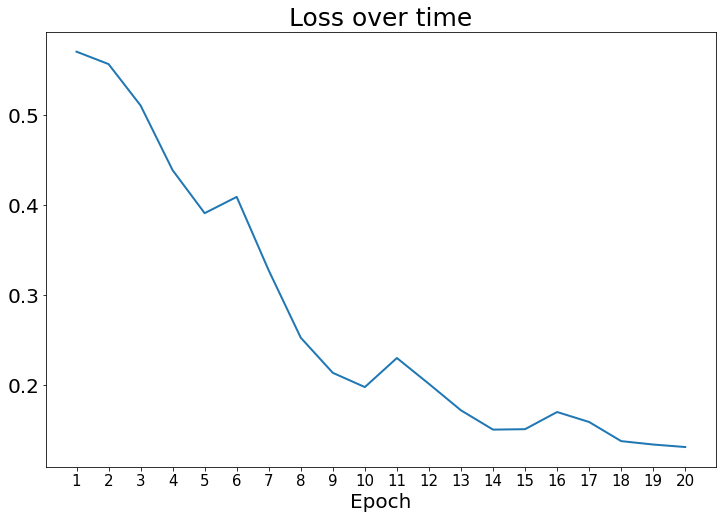

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

train_loss = torch.load("/content/drive/MyDrive/nlp-project/training/english_kbert_20_epochs_loss.pt")
epoch_loss = []
for epoch in train_loss:
  epoch_loss.append(np.mean(epoch))

plt.figure(figsize=(12,8))
plt.plot(range(1, len(epoch_loss) + 1), epoch_loss, linewidth=2)
plt.yticks(fontsize=20)
plt.xticks(range(1, len(epoch_loss) + 1), fontsize=15)
plt.title("Loss over time", fontsize=25)
plt.xlabel("Epoch", fontsize=20)
plt.show()

## Results

##### **BERT-Base, Uncased + ConceptNet** on **ARC-QA** output (first 10 epochs):

```
Vocabulary Size:  30522
[BertClassifier] use visible_matrix: True
[KnowledgeGraph] Loading spo from /content/drive/MyDrive/nlp-project/knowgraphs/ConceptNet5/refined_kg.tsv
[KnowledgeGraph] Bad spo: 	etymologically related to	naan
[KnowledgeGraph] Bad spo: 	form of	naan
[KnowledgeGraph] Bad spo: 	has context	genetics
[KnowledgeGraph] Bad spo: 	has context	mathematics
[KnowledgeGraph] Bad spo: 	has context	law
[KnowledgeGraph] Bad spo: 	has context	computing
[KnowledgeGraph] Bad spo: 	has context	statistics
[KnowledgeGraph] Bad spo: 	has context	computing
[KnowledgeGraph] Bad spo: 	has context	affectionate
[KnowledgeGraph] Bad spo: 	has context	british
[KnowledgeGraph] Bad spo: 	has context	united kingdom

Start training.
Loading sentences from /content/drive/MyDrive/nlp-project/datasets/ARC_QA/Combined/ARC-Combined-Train.tsv
There are 13478 sentence in total. We use 1 processes to inject knowledge into sentences.
Progress of process 0: 0/13478
Progress of process 0: 10000/13478
Shuffling dataset
Trans data to tensor.
input_ids
label_ids
mask_ids
pos_ids
vms
Batch size:  32
The number of training instances: 13478

Epoch id: 1, Training steps: 100, Avg loss: 0.595
Epoch id: 1, Training steps: 200, Avg loss: 0.559
Epoch id: 1, Training steps: 300, Avg loss: 0.572
Epoch id: 1, Training steps: 400, Avg loss: 0.564

Start evaluation on dev dataset.
confusion matrix:
tensor([[2606,  869],
        [   0,    0]])
Report precision, recall, and f1:
Label 0: 0.750, 1.000, 0.857
Label 1: nan, 0.000, nan
Acc. (Correct/Total): 0.7499 (2606/3475) 

Start evaluation on test dataset.
confusion matrix:
tensor([[10640,  3548],
        [    0,     0]])
Report precision, recall, and f1:
Label 0: 0.750, 1.000, 0.857
Label 1: nan, 0.000, nan
Acc. (Correct/Total): 0.7499 (10640/14188)

Epoch id: 2, Training steps: 100, Avg loss: 0.683
Epoch id: 2, Training steps: 200, Avg loss: 0.549
Epoch id: 2, Training steps: 300, Avg loss: 0.533
Epoch id: 2, Training steps: 400, Avg loss: 0.529

Start evaluation on dev dataset.
confusion matrix:
tensor([[2557,  813],
        [  49,   56]])
Report precision, recall, and f1:
Label 0: 0.759, 0.981, 0.856
Label 1: 0.533, 0.064, 0.115
Acc. (Correct/Total): 0.7519 (2613/3475)

Start evaluation on test dataset.
The number of evaluation instances:  14188
confusion matrix:
tensor([[10477,  3288],
        [  163,   260]])
Report precision, recall, and f1:
Label 0: 0.761, 0.985, 0.859
Label 1: 0.615, 0.073, 0.131
Acc. (Correct/Total): 0.7568 (10737/14188)

Epoch id: 3, Training steps: 100, Avg loss: 0.629
Epoch id: 3, Training steps: 200, Avg loss: 0.480
Epoch id: 3, Training steps: 300, Avg loss: 0.437
Epoch id: 3, Training steps: 400, Avg loss: 0.453

Start evaluation on dev dataset.
confusion matrix:
tensor([[2319,  660],
        [ 287,  209]])
Report precision, recall, and f1:
Label 0: 0.778, 0.890, 0.830
Label 1: 0.421, 0.241, 0.306
Acc. (Correct/Total): 0.7275 (2528/3475)

Epoch id: 4, Training steps: 100, Avg loss: 0.522
Epoch id: 4, Training steps: 200, Avg loss: 0.370
Epoch id: 4, Training steps: 300, Avg loss: 0.361
Epoch id: 4, Training steps: 400, Avg loss: 0.383

Start evaluation on dev dataset.
confusion matrix:
tensor([[2350,  672],
        [ 256,  197]])
Report precision, recall, and f1:
Label 0: 0.778, 0.902, 0.835
Label 1: 0.435, 0.227, 0.298
Acc. (Correct/Total): 0.7329 (2547/3475)

Epoch id: 5, Training steps: 100, Avg loss: 0.410
Epoch id: 5, Training steps: 200, Avg loss: 0.274
Epoch id: 5, Training steps: 300, Avg loss: 0.322
Epoch id: 5, Training steps: 400, Avg loss: 0.331

Start evaluation on dev dataset.
confusion matrix:
tensor([[2355,  681],
        [ 251,  188]])
Report precision, recall, and f1:
Label 0: 0.776, 0.904, 0.835
Label 1: 0.428, 0.216, 0.287
Acc. (Correct/Total): 0.7318 (2543/3475)

Epoch id: 6, Training steps: 100, Avg loss: 0.337
Epoch id: 6, Training steps: 200, Avg loss: 0.219
Epoch id: 6, Training steps: 300, Avg loss: 0.272
Epoch id: 6, Training steps: 400, Avg loss: 0.288

Start evaluation on dev dataset.
confusion matrix:
tensor([[2374,  682],
        [ 232,  187]])
Report precision, recall, and f1:
Label 0: 0.777, 0.911, 0.839
Label 1: 0.446, 0.215, 0.290
Acc. (Correct/Total): 0.7370 (2561/3475)

Epoch id: 7, Training steps: 100, Avg loss: 0.295
Epoch id: 7, Training steps: 200, Avg loss: 0.185
Epoch id: 7, Training steps: 300, Avg loss: 0.232
Epoch id: 7, Training steps: 400, Avg loss: 0.253

Start evaluation on dev dataset.
confusion matrix:
tensor([[2372,  680],
        [ 234,  189]])
Report precision, recall, and f1:
Label 0: 0.777, 0.910, 0.838
Label 1: 0.447, 0.217, 0.293
Acc. (Correct/Total): 0.7370 (2561/3475) 

Epoch id: 8, Training steps: 100, Avg loss: 0.252
Epoch id: 8, Training steps: 200, Avg loss: 0.170
Epoch id: 8, Training steps: 300, Avg loss: 0.194
Epoch id: 8, Training steps: 400, Avg loss: 0.221

Start evaluation on dev dataset.
confusion matrix:
tensor([[2299,  646],
        [ 307,  223]])
Report precision, recall, and f1:
Label 0: 0.781, 0.882, 0.828
Label 1: 0.421, 0.257, 0.319
Acc. (Correct/Total): 0.7258 (2522/3475)

Epoch id: 9, Training steps: 100, Avg loss: 0.239
Epoch id: 9, Training steps: 200, Avg loss: 0.156
Epoch id: 9, Training steps: 300, Avg loss: 0.187
Epoch id: 9, Training steps: 400, Avg loss: 0.193

Start evaluation on dev dataset.
confusion matrix:
tensor([[2260,  646],
        [ 346,  223]])
Report precision, recall, and f1:
Label 0: 0.778, 0.867, 0.820
Label 1: 0.392, 0.257, 0.310
Acc. (Correct/Total): 0.7145 (2483/3475)

Epoch id: 10, Training steps: 100, Avg loss: 0.226
Epoch id: 10, Training steps: 200, Avg loss: 0.160
Epoch id: 10, Training steps: 300, Avg loss: 0.170
Epoch id: 10, Training steps: 400, Avg loss: 0.174

Start evaluation on dev dataset.
confusion matrix:
tensor([[2251,  627],
        [ 355,  242]])
Report precision, recall, and f1:
Label 0: 0.782, 0.864, 0.821
Label 1: 0.405, 0.278, 0.330
Acc. (Correct/Total): 0.7174 (2493/3475)

Final evaluation on the test dataset.
The number of evaluation instances:  14188
confusion matrix:
tensor([[10477,  3288],
        [  163,   260]])
Report precision, recall, and f1:
Label 0: 0.761, 0.985, 0.859
Label 1: 0.615, 0.073, 0.131
Acc. (Correct/Total): 0.7568 (10737/14188) 
```

In [ ]:
#@title Train Loss
train_loss = [0.7470791339874268, 0.7302168607711792, 0.7661505341529846, 0.7478463649749756, 0.7307807803153992, 0.7691190242767334, 0.7424553036689758, 0.7137225866317749, 0.71640545129776, 0.7107938528060913, 0.7100028395652771, 0.6654624342918396, 0.6559137105941772, 0.6769323348999023, 0.6502406597137451, 0.6179835200309753, 0.6195165514945984, 0.6400584578514099, 0.5336642861366272, 0.6065356135368347, 0.6586794257164001, 0.5685550570487976, 0.6851428747177124, 0.48133182525634766, 0.6231335997581482, 0.7343881726264954, 0.5043584704399109, 0.5507469177246094, 0.648073136806488, 0.5068567991256714, 0.7353138327598572, 0.6540653109550476, 0.5561497211456299, 0.5310383439064026, 0.6251174211502075, 0.5188212990760803, 0.6829288601875305, 0.603406548500061, 0.5498887896537781, 0.45453941822052, 0.5248808264732361, 0.5342615246772766, 0.7155497670173645, 0.5707310438156128, 0.5166873335838318, 0.5232206583023071, 0.437346875667572, 0.5554599165916443, 0.6839843392372131, 0.5550857782363892, 0.42078810930252075, 0.6472861170768738, 0.4832765460014343, 0.6372053027153015, 0.5638167262077332, 0.5293086171150208, 0.5840952396392822, 0.6644726991653442, 0.5245472192764282, 0.5585821866989136, 0.5995053052902222, 0.5401194095611572, 0.6971819996833801, 0.5562123656272888, 0.5459436774253845, 0.452006071805954, 0.7143490314483643, 0.5588474869728088, 0.5134164094924927, 0.4516858458518982, 0.5657496452331543, 0.6364647746086121, 0.6027472019195557, 0.5313237905502319, 0.500221312046051, 0.39953166246414185, 0.6422476172447205, 0.5950344800949097, 0.6381872892379761, 0.5769613981246948, 0.49570873379707336, 0.4171634018421173, 0.5602412819862366, 0.643978476524353, 0.5991381406784058, 0.5330002903938293, 0.602615475654602, 0.5673643350601196, 0.5559204816818237, 0.4097577929496765, 0.5563341975212097, 0.5999597311019897, 0.8128855228424072, 0.4857245087623596, 0.6652584075927734, 0.4968285858631134, 0.6376417875289917, 0.613881528377533, 0.5610528588294983, 0.5306100845336914, 0.6789246797561646, 0.3740665316581726, 0.5814605355262756, 0.5417702794075012, 0.5432348847389221, 0.4404471218585968, 0.5596891641616821, 0.5569315552711487, 0.360735148191452, 0.4367362856864929, 0.5647940039634705, 0.5541039705276489, 0.5131237506866455, 0.6292702555656433, 0.6170671582221985, 0.5717689990997314, 0.7263791561126709, 0.3878687024116516, 0.4766315817832947, 0.47978582978248596, 0.530320405960083, 0.43316569924354553, 0.49199047684669495, 0.43873411417007446, 0.5980651378631592, 0.6064139008522034, 0.5272367000579834, 0.7369205355644226, 0.5760936737060547, 0.5750529766082764, 0.5671746730804443, 0.5518282055854797, 0.46833595633506775, 0.4970068633556366, 0.5666588544845581, 0.5013900995254517, 0.4597993791103363, 0.4532487392425537, 0.5925557613372803, 0.5660580992698669, 0.6011126637458801, 0.5880426168441772, 0.6554214358329773, 0.5657748579978943, 0.4592333137989044, 0.6814134120941162, 0.42451828718185425, 0.5290185213088989, 0.4509681761264801, 0.49487560987472534, 0.5906420946121216, 0.7349719405174255, 0.4490434229373932, 0.46686506271362305, 0.6091294288635254, 0.7067715525627136, 0.5122331380844116, 0.5383604764938354, 0.7223266959190369, 0.4989740252494812, 0.5842471122741699, 0.5663333535194397, 0.49338382482528687, 0.6177420616149902, 0.5403437614440918, 0.5316059589385986, 0.4728957712650299, 0.659726619720459, 0.6379372477531433, 0.46029743552207947, 0.5918982625007629, 0.49593648314476013, 0.5419080257415771, 0.5239013433456421, 0.6369935870170593, 0.5095660090446472, 0.6006022095680237, 0.5697247982025146, 0.606769859790802, 0.6276010274887085, 0.6688691973686218, 0.6166161894798279, 0.6489424109458923, 0.7571617364883423, 0.4555106461048126, 0.6061630845069885, 0.7049992680549622, 0.6144716143608093, 0.5773966908454895, 0.6580838561058044, 0.6043581366539001, 0.5944970846176147, 0.6293416023254395, 0.5865998268127441, 0.5842795372009277, 0.6006247997283936, 0.5162150859832764, 0.5542160272598267, 0.5216459035873413, 0.4753226935863495, 0.5782469511032104, 0.756901741027832, 0.5546883940696716, 0.6478976607322693, 0.5543600916862488, 0.6053140759468079, 0.4837239980697632, 0.6804670095443726, 0.577252984046936, 0.4927154779434204, 0.6109114289283752, 0.4879646897315979, 0.5640372037887573, 0.5690208077430725, 0.5172974467277527, 0.464773565530777, 0.527976393699646, 0.5633456110954285, 0.5653971433639526, 0.5325721502304077, 0.6788548827171326, 0.6382570266723633, 0.600016176700592, 0.5238692164421082, 0.5150363445281982, 0.5898970365524292, 0.5952675342559814, 0.5689808130264282, 0.6300480961799622, 0.5397751331329346, 0.7707766890525818, 0.5593745112419128, 0.575735330581665, 0.6229049563407898, 0.5511195659637451, 0.5330415964126587, 0.5955671072006226, 0.48063692450523376, 0.632594108581543, 0.5474050045013428, 0.6010290384292603, 0.45528972148895264, 0.5381114482879639, 0.4954213500022888, 0.5187387466430664, 0.41979891061782837, 0.6181788444519043, 0.5289746522903442, 0.47271859645843506, 0.6650325059890747, 0.4417497515678406, 0.7573270201683044, 0.6203181147575378, 0.504010021686554, 0.6057435274124146, 0.6282645463943481, 0.6143033504486084, 0.4772481322288513, 0.5686241388320923, 0.5794513821601868, 0.6000527143478394, 0.5514099597930908, 0.4910348951816559, 0.5309593677520752, 0.5368240475654602, 0.45176318287849426, 0.6552816033363342, 0.7986606359481812, 0.4944813847541809, 0.5447205901145935, 0.5176808834075928, 0.6008015871047974, 0.5682441592216492, 0.5593194961547852, 0.6414527297019958, 0.44642648100852966, 0.558850109577179, 0.44672656059265137, 0.45657840371131897, 0.508778989315033, 0.502807080745697, 0.6181856393814087, 0.7267776131629944, 0.5923852324485779, 0.5262156128883362, 0.5551262497901917, 0.5103960633277893, 0.7089483141899109, 0.5267566442489624, 0.6475672125816345, 0.5637920498847961, 0.5225881338119507, 0.5307580828666687, 0.6964135766029358, 0.6432594656944275, 0.6347895860671997, 0.6945434808731079, 0.6562638878822327, 0.6110121011734009, 0.5922831892967224, 0.527976930141449, 0.47825121879577637, 0.6602108478546143, 0.6386187076568604, 0.5688834190368652, 0.44776108860969543, 0.4940188527107239, 0.5652808547019958, 0.6541170477867126, 0.5891841650009155, 0.46276047825813293, 0.6795548796653748, 0.4386805593967438, 0.5630322694778442, 0.7657874822616577, 0.6673519015312195, 0.5739749073982239, 0.4921731948852539, 0.6951953768730164, 0.49448999762535095, 0.6304965019226074, 0.6626816391944885, 0.4090884327888489, 0.6116794347763062, 0.6788814067840576, 0.6738371849060059, 0.6563166379928589, 0.5411584973335266, 0.6675833463668823, 0.5477620363235474, 0.5203431844711304, 0.5139498114585876, 0.444783478975296, 0.5850382447242737, 0.5502187609672546, 0.5208123326301575, 0.539784848690033, 0.4735807180404663, 0.6648948192596436, 0.5346179604530334, 0.5916516780853271, 0.5682035088539124, 0.4406551420688629, 0.5218260884284973, 0.4903852045536041, 0.5767050981521606, 0.6673644781112671, 0.5424976348876953, 0.5360709428787231, 0.7729860544204712, 0.6622813940048218, 0.5090838074684143, 0.6677278876304626, 0.5971936583518982, 0.5378116369247437, 0.38426145911216736, 0.5071825981140137, 0.5807921886444092, 0.4977973997592926, 0.5869530439376831, 0.4595182240009308, 0.5189534425735474, 0.456317663192749, 0.5374101996421814, 0.6422463059425354, 0.6750692129135132, 0.6731212735176086, 0.6574498414993286, 0.48708292841911316, 0.6671203970909119, 0.5219452977180481, 0.5602156519889832, 0.6004770994186401, 0.6005229353904724, 0.5874441266059875, 0.5848492383956909, 0.556939959526062, 0.5973690748214722, 0.44073185324668884, 0.5772372484207153, 0.5035072565078735, 0.5491811037063599, 0.4896593689918518, 0.569582462310791, 0.4850023090839386, 0.557166576385498, 0.4134370684623718, 0.7251602411270142, 0.4955497682094574, 0.6120951175689697, 0.5146262049674988, 0.3629665970802307, 0.526376485824585, 0.6481591463088989, 0.5384033918380737, 0.5099775195121765, 0.6353732943534851, 0.5496105551719666, 0.6933131814002991, 0.4916048049926758, 0.47474777698516846, 0.358318567276001, 0.4814436435699463, 0.5385342836380005, 0.6439130306243896, 0.5396541953086853, 0.45559945702552795, 0.5037198662757874, 0.6865671277046204, 0.45951926708221436, 0.5253079533576965, 0.4451936185359955, 0.41398173570632935, 0.5684376358985901, 0.43365833163261414, 0.5609169602394104, 0.5791805386543274, 0.6880373954772949, 0.5314264297485352, 0.6557154655456543, 0.5164650082588196, 0.45760226249694824, 0.7250325679779053, 0.5436394810676575, 0.49586841464042664, 0.5730652213096619, 0.4849880635738373, 0.48662588000297546, 0.5297818779945374, 0.5437466502189636, 0.6385745406150818, 0.5356257557868958, 0.7180476188659668, 0.563789427280426, 0.5402095913887024, 0.6596594452857971, 0.5110822916030884, 0.5636054873466492, 0.595272958278656, 0.619968056678772, 0.470215380191803, 0.570061206817627, 0.686337947845459, 0.5624472498893738, 0.7166436314582825, 0.46233242750167847, 0.599518895149231, 0.7738326191902161, 0.49857476353645325, 0.5561739206314087, 0.6127451658248901, 0.49440231919288635, 0.7140951156616211, 0.6344125270843506, 0.5654885768890381, 0.5508920550346375, 0.6208606362342834, 0.5433218479156494, 0.6491354703903198, 0.5910788774490356, 0.5411925911903381, 0.4465543329715729, 0.5098587274551392, 0.5486346483230591, 0.7171038389205933, 0.562856912612915, 0.5510242581367493, 0.5243032574653625, 0.4285435378551483, 0.5760566592216492, 0.6972787380218506, 0.5443858504295349, 0.38310685753822327, 0.6379115581512451, 0.49359792470932007, 0.6203821301460266, 0.536600649356842, 0.5053479075431824, 0.6067001819610596, 0.6620775461196899, 0.5199252963066101, 0.5499728322029114, 0.6031218767166138, 0.5405632853507996, 0.7114958763122559, 0.5485966205596924, 0.5516741275787354, 0.4899207055568695, 0.6813398599624634, 0.5383570790290833, 0.526691198348999, 0.457316517829895, 0.5885744690895081, 0.6346820592880249, 0.5622706413269043, 0.5728092193603516, 0.4703356623649597, 0.3917029798030853, 0.6255347728729248, 0.6042616367340088, 0.6710014939308167, 0.5768038630485535, 0.5009399056434631, 0.3709947466850281, 0.5367995500564575, 0.6406981348991394, 0.6047044396400452, 0.526535153388977, 0.5947272777557373, 0.562755286693573, 0.5586606860160828, 0.40789705514907837, 0.551637589931488, 0.5660409927368164, 0.7855764627456665, 0.4581845998764038, 0.6410091519355774, 0.5097187161445618, 0.6214074492454529, 0.5987905263900757, 0.5280568599700928, 0.4805476665496826, 0.6323917508125305, 0.39332863688468933, 0.5635643601417542, 0.5416812896728516, 0.5202842950820923, 0.41255319118499756, 0.5912219285964966, 0.5419700145721436, 0.33806636929512024, 0.411356657743454, 0.6141656041145325, 0.5927107930183411, 0.50377357006073, 0.6136221289634705, 0.5898359417915344, 0.6006214618682861, 0.7376282811164856, 0.3748815655708313, 0.484170526266098, 0.4721020460128784, 0.5305384993553162, 0.43977248668670654, 0.4938715696334839, 0.43641242384910583, 0.5940053462982178, 0.5802608132362366, 0.5280757546424866, 0.7044051885604858, 0.534138560295105, 0.5618560910224915, 0.5553511381149292, 0.5484742522239685, 0.4352516829967499, 0.45590853691101074, 0.5752717852592468, 0.5000273585319519, 0.4533228576183319, 0.43192726373672485, 0.6048434972763062, 0.5480268001556396, 0.6065895557403564, 0.6071548461914062, 0.683509111404419, 0.5240383744239807, 0.4534211754798889, 0.6463407278060913, 0.42148256301879883, 0.5237056612968445, 0.44994989037513733, 0.46239742636680603, 0.5821042656898499, 0.7199491262435913, 0.4683232307434082, 0.4772278666496277, 0.5822306275367737, 0.6780939102172852, 0.5129111409187317, 0.5300503373146057, 0.7206135988235474, 0.5033490061759949, 0.5517105460166931, 0.5400455594062805, 0.47063398361206055, 0.6010957360267639, 0.5305355787277222, 0.49971821904182434, 0.47136521339416504, 0.6246626973152161, 0.6421825885772705, 0.43279922008514404, 0.5623314380645752, 0.47669410705566406, 0.5081415176391602, 0.5227042436599731, 0.6400364637374878, 0.5171455144882202, 0.5779024362564087, 0.5323099493980408, 0.6061809062957764, 0.6241271495819092, 0.642256498336792, 0.636372447013855, 0.6335634589195251, 0.7375636100769043, 0.4899461269378662, 0.5654857754707336, 0.6958292126655579, 0.5647553205490112, 0.6050482988357544, 0.616514265537262, 0.5891937613487244, 0.6010141372680664, 0.6060492396354675, 0.56618332862854, 0.5867859125137329, 0.6109029054641724, 0.5016253590583801, 0.5205652713775635, 0.4970719814300537, 0.4656267464160919, 0.5572096705436707, 0.747395932674408, 0.5294084548950195, 0.6464590430259705, 0.5658559799194336, 0.5634419322013855, 0.4747938811779022, 0.664633572101593, 0.6099961996078491, 0.5004947185516357, 0.6079071164131165, 0.4719886779785156, 0.5619871616363525, 0.5477942228317261, 0.4889591932296753, 0.46204134821891785, 0.4830645024776459, 0.5267699956893921, 0.5638121962547302, 0.524519145488739, 0.6770731806755066, 0.643419623374939, 0.5957834124565125, 0.5117138624191284, 0.5287004113197327, 0.5781495571136475, 0.5751304030418396, 0.5453696250915527, 0.5940250158309937, 0.5323582887649536, 0.7480936050415039, 0.5568430423736572, 0.5591733455657959, 0.6087479591369629, 0.5587683916091919, 0.4855211675167084, 0.5937814712524414, 0.4527081847190857, 0.6282978057861328, 0.5415679216384888, 0.5854364633560181, 0.4252578914165497, 0.5830270051956177, 0.43430182337760925, 0.508876621723175, 0.4219326674938202, 0.5739933848381042, 0.5190609097480774, 0.45479097962379456, 0.6141276359558105, 0.41080141067504883, 0.7194545269012451, 0.5889154076576233, 0.4230782389640808, 0.4960419237613678, 0.4904623031616211, 0.6955835223197937, 0.37793636322021484, 0.5033959746360779, 0.49711981415748596, 0.5284773707389832, 0.4681191146373749, 0.3510817885398865, 0.4441470205783844, 0.522667646408081, 0.4121250510215759, 0.6381186842918396, 0.7172308564186096, 0.3907915949821472, 0.4740556478500366, 0.47042691707611084, 0.5361552238464355, 0.5791210532188416, 0.4935876429080963, 0.6056075692176819, 0.3469918966293335, 0.5415705442428589, 0.40784868597984314, 0.39942216873168945, 0.44751641154289246, 0.47530293464660645, 0.5981361269950867, 0.7273731827735901, 0.46924614906311035, 0.4586326479911804, 0.5392140746116638, 0.45880353450775146, 0.5805934071540833, 0.46404725313186646, 0.5533851981163025, 0.4664737284183502, 0.4716086983680725, 0.39767390489578247, 0.5430073738098145, 0.6011064648628235, 0.6497717499732971, 0.6396949887275696, 0.5011762976646423, 0.5400772094726562, 0.49557146430015564, 0.6194604635238647, 0.45512455701828003, 0.648535430431366, 0.7150884866714478, 0.5001020431518555, 0.3483927845954895, 0.4955281615257263, 0.5470566153526306, 0.6665953993797302, 0.5176321864128113, 0.4937494993209839, 0.6674603223800659, 0.3819419741630554, 0.6369863152503967, 0.7683954834938049, 0.5978607535362244, 0.554524838924408, 0.49366605281829834, 0.667356014251709, 0.4861997961997986, 0.6167585253715515, 0.6380903720855713, 0.42733412981033325, 0.5578462481498718, 0.6523528099060059, 0.6386348009109497, 0.6559311151504517, 0.5255224704742432, 0.6254035234451294, 0.5084277987480164, 0.5199582576751709, 0.5140256285667419, 0.3886704742908478, 0.5554850101470947, 0.5318940877914429, 0.4531809985637665, 0.5212503671646118, 0.444924533367157, 0.5975183844566345, 0.49240997433662415, 0.49572616815567017, 0.5126834511756897, 0.4154658615589142, 0.48899710178375244, 0.4527367055416107, 0.5477920770645142, 0.55739825963974, 0.5163208842277527, 0.4914166331291199, 0.7921061515808105, 0.7022468447685242, 0.4863734245300293, 0.6824880838394165, 0.5724440217018127, 0.5196330547332764, 0.32771530747413635, 0.49381208419799805, 0.5550659894943237, 0.45628029108047485, 0.5412877202033997, 0.4239017367362976, 0.4394822120666504, 0.4680030345916748, 0.5206934213638306, 0.6262615919113159, 0.5907294750213623, 0.5697441101074219, 0.64947509765625, 0.4346674382686615, 0.6531921625137329, 0.5241715312004089, 0.5120930671691895, 0.5906752943992615, 0.6465738415718079, 0.5662511587142944, 0.4448964595794678, 0.49103233218193054, 0.5984969735145569, 0.4006415903568268, 0.5404661297798157, 0.48450762033462524, 0.46909454464912415, 0.43126553297042847, 0.5225247144699097, 0.3918033838272095, 0.483194500207901, 0.3579731285572052, 0.6729850769042969, 0.4167495369911194, 0.5586081147193909, 0.4393031597137451, 0.2966765761375427, 0.5106746554374695, 0.4824789762496948, 0.5212539434432983, 0.39553824067115784, 0.5389288663864136, 0.41331201791763306, 0.6311022043228149, 0.4271283745765686, 0.4558093845844269, 0.38858190178871155, 0.4486270844936371, 0.3753621280193329, 0.5874654054641724, 0.5073713660240173, 0.38046354055404663, 0.42823731899261475, 0.6538820862770081, 0.533328115940094, 0.5011761784553528, 0.3903994560241699, 0.41033127903938293, 0.5512550473213196, 0.38300377130508423, 0.5392296314239502, 0.6055562496185303, 0.6883828639984131, 0.4621535539627075, 0.6997423768043518, 0.45126476883888245, 0.3999654948711395, 0.6787024736404419, 0.49672502279281616, 0.4517095685005188, 0.4858701229095459, 0.47402599453926086, 0.47746357321739197, 0.5269261002540588, 0.46463900804519653, 0.6185541749000549, 0.4839216470718384, 0.7029117345809937, 0.544746994972229, 0.4970511496067047, 0.6628506183624268, 0.522616446018219, 0.6002045273780823, 0.6171471476554871, 0.6340951919555664, 0.4337242543697357, 0.5734648704528809, 0.7220520377159119, 0.481688529253006, 0.6481803059577942, 0.4366806745529175, 0.5210633277893066, 0.8367874026298523, 0.4822313189506531, 0.5014398097991943, 0.6018737554550171, 0.4518360495567322, 0.6528548002243042, 0.6024723052978516, 0.5315649509429932, 0.5401649475097656, 0.6051854491233826, 0.5430346131324768, 0.6170232892036438, 0.5338068604469299, 0.5034752488136292, 0.35989803075790405, 0.4252752959728241, 0.5528214573860168, 0.7232608795166016, 0.48461565375328064, 0.5270574688911438, 0.46870699524879456, 0.42812806367874146, 0.605070948600769, 0.6164244413375854, 0.4375093877315521, 0.3233116865158081, 0.6129822731018066, 0.543438196182251, 0.5554746985435486, 0.5087369680404663, 0.44951117038726807, 0.5524381995201111, 0.5233624577522278, 0.49945563077926636, 0.5190170407295227, 0.5003690719604492, 0.38275083899497986, 0.7490672469139099, 0.4781745672225952, 0.422488808631897, 0.3903757333755493, 0.4861436188220978, 0.3795586824417114, 0.46709638833999634, 0.4017215371131897, 0.48136255145072937, 0.5290091633796692, 0.45427587628364563, 0.5318698287010193, 0.35238343477249146, 0.36604493856430054, 0.549177885055542, 0.45542195439338684, 0.5355771780014038, 0.5825045704841614, 0.4390913248062134, 0.2277994304895401, 0.4274536967277527, 0.6639919877052307, 0.6383248567581177, 0.5161746144294739, 0.5388836860656738, 0.5186687111854553, 0.5178129076957703, 0.39891940355300903, 0.5600007772445679, 0.5054725408554077, 0.7274495959281921, 0.3532699644565582, 0.6206092834472656, 0.4669926166534424, 0.5933439135551453, 0.5514137148857117, 0.45021384954452515, 0.39672231674194336, 0.4847944378852844, 0.31102678179740906, 0.5201621651649475, 0.42650115489959717, 0.4040378928184509, 0.3918725252151489, 0.42072564363479614, 0.4637759029865265, 0.3357605040073395, 0.402118057012558, 0.5229398012161255, 0.4372153580188751, 0.47408828139305115, 0.4931638836860657, 0.5256409645080566, 0.4629513919353485, 0.6744166612625122, 0.3335544764995575, 0.3770716190338135, 0.3556760847568512, 0.5374025106430054, 0.33790794014930725, 0.40059608221054077, 0.3666834831237793, 0.5415518283843994, 0.5156803727149963, 0.4932747483253479, 0.6899040341377258, 0.4694337546825409, 0.5716078281402588, 0.58870929479599, 0.4850640594959259, 0.4124179482460022, 0.4348067045211792, 0.5383098125457764, 0.47058993577957153, 0.4213222861289978, 0.40756046772003174, 0.48661941289901733, 0.4708062708377838, 0.5246033668518066, 0.5367552042007446, 0.5730534195899963, 0.4370999038219452, 0.39132192730903625, 0.5002208352088928, 0.3336374759674072, 0.4718097746372223, 0.3449234962463379, 0.42758429050445557, 0.4680633544921875, 0.6340188980102539, 0.35085535049438477, 0.39959046244621277, 0.47478970885276794, 0.6494033932685852, 0.4034133851528168, 0.5588500499725342, 0.7100227475166321, 0.4866844117641449, 0.40696194767951965, 0.5142199993133545, 0.4964061975479126, 0.4516579210758209, 0.4665561318397522, 0.44102126359939575, 0.3650640845298767, 0.5195678472518921, 0.5361974835395813, 0.41529107093811035, 0.5169553160667419, 0.45722880959510803, 0.4305914640426636, 0.48665711283683777, 0.46378618478775024, 0.4371289610862732, 0.533037543296814, 0.46352559328079224, 0.46271929144859314, 0.5414552092552185, 0.5515609383583069, 0.5754745006561279, 0.5430943965911865, 0.6947255730628967, 0.38048022985458374, 0.43281736969947815, 0.6219790577888489, 0.5311897397041321, 0.5743957757949829, 0.56300950050354, 0.6064918041229248, 0.43119898438453674, 0.48300373554229736, 0.465836763381958, 0.5749486088752747, 0.567200779914856, 0.4626169204711914, 0.4351886212825775, 0.48259708285331726, 0.5174408555030823, 0.48757776618003845, 0.5955740213394165, 0.48469048738479614, 0.5956193208694458, 0.49698179960250854, 0.49961912631988525, 0.46125170588493347, 0.5879203081130981, 0.6983701586723328, 0.4279380440711975, 0.5805323123931885, 0.460860013961792, 0.5231348872184753, 0.49526599049568176, 0.469414621591568, 0.46822667121887207, 0.4716506600379944, 0.4459827244281769, 0.5826410055160522, 0.48907744884490967, 0.6605126857757568, 0.5890486836433411, 0.5626428127288818, 0.4624203145503998, 0.5108922719955444, 0.5440424084663391, 0.5537932515144348, 0.5134478211402893, 0.5608530044555664, 0.4753270149230957, 0.7009733319282532, 0.5210179686546326, 0.49248871207237244, 0.5468237400054932, 0.47945070266723633, 0.40400204062461853, 0.5118187665939331, 0.40070533752441406, 0.45484480261802673, 0.41200974583625793, 0.5178548693656921, 0.39446213841438293, 0.5479541420936584, 0.32637858390808105, 0.4245968163013458, 0.4106525480747223, 0.45135846734046936, 0.42285922169685364, 0.3943798243999481, 0.4740920066833496, 0.3285594582557678, 0.6766306757926941, 0.5682324767112732, 0.3674751818180084, 0.3726450204849243, 0.40088531374931335, 0.4439348876476288, 0.280095636844635, 0.3117940127849579, 0.33787623047828674, 0.3837738633155823, 0.2012064903974533, 0.15021491050720215, 0.24817804992198944, 0.24000343680381775, 0.247584268450737, 0.2627299726009369, 0.4222065508365631, 0.22096318006515503, 0.3144640624523163, 0.5463050603866577, 0.4439069628715515, 0.4595341980457306, 0.3499044179916382, 0.5363500714302063, 0.23076283931732178, 0.4590870440006256, 0.2526210844516754, 0.29579225182533264, 0.3488173484802246, 0.46416929364204407, 0.5107899904251099, 0.6045112609863281, 0.31417959928512573, 0.3224456012248993, 0.4594440460205078, 0.376360148191452, 0.4692031741142273, 0.3377522826194763, 0.3951607346534729, 0.3163825571537018, 0.3752591013908386, 0.2135542929172516, 0.3789845108985901, 0.40888136625289917, 0.395351767539978, 0.48626708984375, 0.42909306287765503, 0.36977633833885193, 0.31665292382240295, 0.40589866042137146, 0.30828678607940674, 0.44768914580345154, 0.5104864239692688, 0.307092547416687, 0.2805141806602478, 0.2898930013179779, 0.3739016056060791, 0.49583306908607483, 0.48936426639556885, 0.44474324584007263, 0.6480106711387634, 0.2629944086074829, 0.6162794828414917, 0.6369096040725708, 0.527041494846344, 0.643048107624054, 0.4414478540420532, 0.6604441404342651, 0.4588571786880493, 0.6302584409713745, 0.6270111203193665, 0.3926771283149719, 0.5811964273452759, 0.5924019813537598, 0.5195810794830322, 0.6767045259475708, 0.4887673258781433, 0.6041526198387146, 0.4808221459388733, 0.5048370957374573, 0.5309731960296631, 0.3709123134613037, 0.5748814940452576, 0.5152642130851746, 0.41334179043769836, 0.5010113716125488, 0.3999398350715637, 0.5339210629463196, 0.48266565799713135, 0.4509924650192261, 0.4783105254173279, 0.3735562562942505, 0.4682413637638092, 0.43613892793655396, 0.4734051823616028, 0.5036925673484802, 0.453280508518219, 0.4908568561077118, 0.6554244756698608, 0.6454105973243713, 0.4415782392024994, 0.5168098211288452, 0.46534034609794617, 0.4405956268310547, 0.268096923828125, 0.4142954647541046, 0.48456066846847534, 0.39553698897361755, 0.48723074793815613, 0.3984428942203522, 0.30796223878860474, 0.4018794596195221, 0.4367702603340149, 0.6025261878967285, 0.5499410033226013, 0.4977957606315613, 0.5731613636016846, 0.34751537442207336, 0.6268342137336731, 0.3678697645664215, 0.37068530917167664, 0.4940152168273926, 0.5693541169166565, 0.49398839473724365, 0.31488093733787537, 0.4350162744522095, 0.5439493656158447, 0.3330499827861786, 0.5096336603164673, 0.46508458256721497, 0.3117977976799011, 0.26796722412109375, 0.3739633560180664, 0.28536558151245117, 0.33373457193374634, 0.29649022221565247, 0.4923630356788635, 0.33957457542419434, 0.41382959485054016, 0.369100958108902, 0.2093653678894043, 0.4122449457645416, 0.3000462055206299, 0.4884639084339142, 0.30412524938583374, 0.39424335956573486, 0.31335192918777466, 0.3711133599281311, 0.37301090359687805, 0.36085033416748047, 0.27233216166496277, 0.3037412166595459, 0.2712227702140808, 0.5189679861068726, 0.4394054412841797, 0.30442461371421814, 0.36458757519721985, 0.40210598707199097, 0.30468517541885376, 0.25971779227256775, 0.2681024670600891, 0.3093358278274536, 0.5023886561393738, 0.2815425992012024, 0.5008861422538757, 0.5458385348320007, 0.502225399017334, 0.48672470450401306, 0.5181800127029419, 0.2372683733701706, 0.2457595318555832, 0.6567825675010681, 0.32046058773994446, 0.3673646152019501, 0.32650765776634216, 0.3858911395072937, 0.4685477614402771, 0.5625853538513184, 0.3695133924484253, 0.4419618844985962, 0.4851655662059784, 0.5604743361473083, 0.4882626235485077, 0.3096776604652405, 0.7396702170372009, 0.511735200881958, 0.6253559589385986, 0.5938477516174316, 0.44465363025665283, 0.41280460357666016, 0.6279708743095398, 0.6571000218391418, 0.3432106375694275, 0.5519687533378601, 0.3288823962211609, 0.4613189399242401, 0.8718802332878113, 0.4307042062282562, 0.4042210876941681, 0.5055609345436096, 0.37436285614967346, 0.4628008306026459, 0.4806179702281952, 0.4749172329902649, 0.5439176559448242, 0.5169968008995056, 0.45880088210105896, 0.46496662497520447, 0.4405672550201416, 0.41060855984687805, 0.2769375741481781, 0.31675538420677185, 0.5222437381744385, 0.6870357394218445, 0.3920162618160248, 0.5251855850219727, 0.3717319667339325, 0.3305385708808899, 0.5594874024391174, 0.6619970202445984, 0.217638298869133, 0.30874672532081604, 0.5887349843978882, 0.5510871410369873, 0.4268118739128113, 0.5383514165878296, 0.3881879150867462, 0.43492820858955383, 0.4225166440010071, 0.35127633810043335, 0.4286956191062927, 0.4026573598384857, 0.27804064750671387, 0.6273098587989807, 0.38458743691444397, 0.34276580810546875, 0.2512022852897644, 0.5098996758460999, 0.22819949686527252, 0.414659708738327, 0.30098196864128113, 0.3512348234653473, 0.3671301007270813, 0.2565270662307739, 0.45403069257736206, 0.283049613237381, 0.28850412368774414, 0.4432838559150696, 0.42318016290664673, 0.48073989152908325, 0.5137026309967041, 0.3382719159126282, 0.21033385396003723, 0.36280372738838196, 0.4929988384246826, 0.4193660020828247, 0.37105801701545715, 0.4665660858154297, 0.2784595191478729, 0.48376166820526123, 0.20903968811035156, 0.41664543747901917, 0.5180029273033142, 0.7518251538276672, 0.27518436312675476, 0.615364134311676, 0.43839138746261597, 0.4245700538158417, 0.4366194009780884, 0.3865264654159546, 0.27999335527420044, 0.29826414585113525, 0.24493856728076935, 0.44024786353111267, 0.37854722142219543, 0.3389250636100769, 0.26286521553993225, 0.36509978771209717, 0.3850945234298706, 0.26382976770401, 0.2825915813446045, 0.4136592745780945, 0.349008172750473, 0.3611273467540741, 0.4128124713897705, 0.4206084907054901, 0.41819483041763306, 0.691313624382019, 0.2709008455276489, 0.25447559356689453, 0.20261478424072266, 0.41759049892425537, 0.31579938530921936, 0.2101411074399948, 0.26229244470596313, 0.4465354084968567, 0.22987976670265198, 0.423867404460907, 0.5899099111557007, 0.33531710505485535, 0.509288489818573, 0.5537427663803101, 0.3237614631652832, 0.31188076734542847, 0.35525935888290405, 0.4151233732700348, 0.3226567208766937, 0.32904183864593506, 0.2776027321815491, 0.41208526492118835, 0.43506497144699097, 0.3644876480102539, 0.4601327180862427, 0.3555985689163208, 0.3275196850299835, 0.3980215787887573, 0.38399580121040344, 0.2061789333820343, 0.30064189434051514, 0.23581579327583313, 0.35357990860939026, 0.32199132442474365, 0.43147042393684387, 0.21834205090999603, 0.3603983521461487, 0.30345290899276733, 0.4449240565299988, 0.2679590880870819, 0.41084709763526917, 0.6083223819732666, 0.3821275532245636, 0.31789231300354004, 0.36228126287460327, 0.2972582280635834, 0.33784860372543335, 0.3175194561481476, 0.3501404821872711, 0.27099379897117615, 0.3712136447429657, 0.37534886598587036, 0.28712353110313416, 0.36759912967681885, 0.30890655517578125, 0.4179989695549011, 0.3593251407146454, 0.3033352196216583, 0.4984629452228546, 0.2261018306016922, 0.34360918402671814, 0.4177806079387665, 0.4911152422428131, 0.4752623438835144, 0.2314922958612442, 0.3576342463493347, 0.4731864631175995, 0.3708348572254181, 0.28363659977912903, 0.37060287594795227, 0.3452323079109192, 0.41462230682373047, 0.690868616104126, 0.615451991558075, 0.3030568063259125, 0.4785410165786743, 0.4209924340248108, 0.3936897814273834, 0.5278190970420837, 0.5058872699737549, 0.2974371314048767, 0.3999038636684418, 0.3530901372432709, 0.46952274441719055, 0.4423905313014984, 0.3568231463432312, 0.5611947774887085, 0.4740503132343292, 0.44100114703178406, 0.49290937185287476, 0.4529224932193756, 0.6650844812393188, 0.3932247459888458, 0.4613836407661438, 0.36474525928497314, 0.4661727249622345, 0.4469609558582306, 0.4455074369907379, 0.4132009446620941, 0.3727218508720398, 0.3867534399032593, 0.544369101524353, 0.42427635192871094, 0.6328717470169067, 0.5557363629341125, 0.5929309725761414, 0.4526415467262268, 0.5006680488586426, 0.5041168928146362, 0.47986534237861633, 0.4331197142601013, 0.52055424451828, 0.4629921615123749, 0.5854135751724243, 0.45477163791656494, 0.45585939288139343, 0.513181209564209, 0.4455050528049469, 0.36025068163871765, 0.4404698610305786, 0.28148356080055237, 0.3643708825111389, 0.3512234687805176, 0.4260183274745941, 0.306010365486145, 0.39831018447875977, 0.25072067975997925, 0.3544798493385315, 0.32711106538772583, 0.2868158519268036, 0.34909507632255554, 0.2898866534233093, 0.39651763439178467, 0.29413244128227234, 0.48436158895492554, 0.38911738991737366, 0.20719081163406372, 0.30266252160072327, 0.25608858466148376, 0.23109689354896545, 0.18409448862075806, 0.18163397908210754, 0.26428118348121643, 0.3429388701915741, 0.14601467549800873, 0.07756137102842331, 0.22788624465465546, 0.21629905700683594, 0.212967187166214, 0.2776162028312683, 0.29279300570487976, 0.20242828130722046, 0.1726403385400772, 0.2321007251739502, 0.22048479318618774, 0.47981905937194824, 0.24252547323703766, 0.3732381761074066, 0.30014604330062866, 0.3352736532688141, 0.15971964597702026, 0.24828830361366272, 0.4086800813674927, 0.40594151616096497, 0.371813029050827, 0.3701728284358978, 0.21396932005882263, 0.19726255536079407, 0.2791023254394531, 0.2749594449996948, 0.40527066588401794, 0.23680303990840912, 0.3074442148208618, 0.1990441530942917, 0.2869587242603302, 0.1593077927827835, 0.3043176531791687, 0.44332394003868103, 0.4910135269165039, 0.44183167815208435, 0.37132030725479126, 0.31716784834861755, 0.18123677372932434, 0.273735374212265, 0.22064006328582764, 0.33836790919303894, 0.2929297089576721, 0.23239034414291382, 0.23942413926124573, 0.24998699128627777, 0.41030895709991455, 0.24963980913162231, 0.3339681625366211, 0.25281935930252075, 0.5353224277496338, 0.19519998133182526, 0.5652234554290771, 0.313427597284317, 0.35684144496917725, 0.5351799726486206, 0.446468323469162, 0.5047450661659241, 0.4071131944656372, 0.6405729651451111, 0.6182780861854553, 0.27824607491493225, 0.4348030984401703, 0.6516017317771912, 0.5083568692207336, 0.6832144260406494, 0.4661300778388977, 0.5483474731445312, 0.44326645135879517, 0.49952372908592224, 0.5306433439254761, 0.3190866708755493, 0.49714991450309753, 0.47454017400741577, 0.3787112236022949, 0.4475697875022888, 0.4265417456626892, 0.4440024793148041, 0.4024864137172699, 0.47796377539634705, 0.45977598428726196, 0.35107746720314026, 0.4756484627723694, 0.3862677216529846, 0.43419572710990906, 0.42134615778923035, 0.3832731246948242, 0.38555213809013367, 0.47845014929771423, 0.6021425127983093, 0.3610442280769348, 0.4870752990245819, 0.40557125210762024, 0.37623709440231323, 0.22259660065174103, 0.3572138249874115, 0.4461153447628021, 0.3969356417655945, 0.4432639181613922, 0.3654903769493103, 0.27892741560935974, 0.2901410758495331, 0.41157102584838867, 0.5158165693283081, 0.40304213762283325, 0.3873597979545593, 0.4454174339771271, 0.28829681873321533, 0.48526519536972046, 0.236764594912529, 0.38159212470054626, 0.4009799361228943, 0.5221162438392639, 0.42783764004707336, 0.19833984971046448, 0.3892476558685303, 0.45808109641075134, 0.26284411549568176, 0.3872063159942627, 0.36121007800102234, 0.18912576138973236, 0.19711019098758698, 0.27036020159721375, 0.23125891387462616, 0.2828250229358673, 0.2578299343585968, 0.3891877233982086, 0.31644970178604126, 0.3469582796096802, 0.3650035262107849, 0.20507930219173431, 0.29072925448417664, 0.2496551275253296, 0.34893983602523804, 0.2255658656358719, 0.41843584179878235, 0.23651602864265442, 0.300982266664505, 0.3064846396446228, 0.25255969166755676, 0.22231552004814148, 0.2096441239118576, 0.2499057799577713, 0.45417991280555725, 0.3022018074989319, 0.2539791762828827, 0.28873199224472046, 0.37789300084114075, 0.24827495217323303, 0.22818756103515625, 0.17290042340755463, 0.1847946047782898, 0.3136832118034363, 0.1895541399717331, 0.3938808739185333, 0.4364289343357086, 0.3913516700267792, 0.3234260082244873, 0.5566339492797852, 0.10594828426837921, 0.03698623925447464, 0.49634119868278503, 0.3012700080871582, 0.3340443968772888, 0.31518590450286865, 0.18937215209007263, 0.23426444828510284, 0.3668912351131439, 0.2709237039089203, 0.4803515076637268, 0.35805439949035645, 0.4928172826766968, 0.35352274775505066, 0.28525689244270325, 0.47948890924453735, 0.38596436381340027, 0.41651564836502075, 0.5043831467628479, 0.34353989362716675, 0.2662479281425476, 0.44195348024368286, 0.7730798125267029, 0.22472462058067322, 0.5026890635490417, 0.22813501954078674, 0.5179957747459412, 0.7467070817947388, 0.29449406266212463, 0.3546462655067444, 0.48878228664398193, 0.2135079950094223, 0.4050128161907196, 0.2976934313774109, 0.4529741704463959, 0.4134483337402344, 0.4091876745223999, 0.44908586144447327, 0.42770981788635254, 0.40365055203437805, 0.3031284511089325, 0.26557594537734985, 0.27279698848724365, 0.4309483766555786, 0.5841573476791382, 0.27783581614494324, 0.33406713604927063, 0.27898141741752625, 0.3120255768299103, 0.33667635917663574, 0.4205775558948517, 0.2828315496444702, 0.2752119302749634, 0.46824920177459717, 0.5713183879852295, 0.31965216994285583, 0.4166852831840515, 0.2953004837036133, 0.3376411497592926, 0.3711834251880646, 0.34277111291885376, 0.27731844782829285, 0.3194158673286438, 0.2128441035747528, 0.5793635845184326, 0.2571428716182709, 0.35306212306022644, 0.1809600442647934, 0.33961522579193115, 0.15171003341674805, 0.27590441703796387, 0.2794460356235504, 0.27409541606903076, 0.3561675548553467, 0.28562477231025696, 0.28273412585258484, 0.20646719634532928, 0.23374630510807037, 0.2948661148548126, 0.24654284119606018, 0.345367968082428, 0.39801281690597534, 0.38165247440338135, 0.13694830238819122, 0.308994323015213, 0.581121027469635, 0.372336208820343, 0.4144989848136902, 0.3303458094596863, 0.16277754306793213, 0.3834230899810791, 0.1258591264486313, 0.29209837317466736, 0.2787914276123047, 0.41761255264282227, 0.1964842826128006, 0.5213088393211365, 0.2265865057706833, 0.42897850275039673, 0.27443042397499084, 0.2670159637928009, 0.14702729880809784, 0.2493632733821869, 0.1295357495546341, 0.3447650372982025, 0.23932935297489166, 0.18379727005958557, 0.21423444151878357, 0.1596713811159134, 0.34904852509498596, 0.2651893198490143, 0.23722408711910248, 0.34501948952674866, 0.3445330560207367, 0.34055081009864807, 0.26345810294151306, 0.3193129599094391, 0.3529706597328186, 0.4533352255821228, 0.27135586738586426, 0.246660053730011, 0.1966690868139267, 0.3374529778957367, 0.2538209855556488, 0.14999428391456604, 0.24104978144168854, 0.23071978986263275, 0.26453664898872375, 0.345817506313324, 0.562558114528656, 0.1902594268321991, 0.2962873578071594, 0.296402245759964, 0.24786603450775146, 0.21605554223060608, 0.18400028347969055, 0.3060952126979828, 0.2778905928134918, 0.22426731884479523, 0.21042528748512268, 0.29575297236442566, 0.260504812002182, 0.3174237012863159, 0.37573230266571045, 0.30437424778938293, 0.2707221210002899, 0.2372087836265564, 0.36024874448776245, 0.2363082617521286, 0.17627732455730438, 0.2245018035173416, 0.14444851875305176, 0.34395521879196167, 0.2517900764942169, 0.1041281670331955, 0.32835647463798523, 0.21693551540374756, 0.4281902611255646, 0.26180410385131836, 0.24136225879192352, 0.42253249883651733, 0.26482442021369934, 0.3245163857936859, 0.2571509778499603, 0.1761116087436676, 0.37226763367652893, 0.20062173902988434, 0.23814381659030914, 0.2118106633424759, 0.32354822754859924, 0.3622249662876129, 0.1970239281654358, 0.21674145758152008, 0.26060593128204346, 0.18408027291297913, 0.1587783694267273, 0.2669858932495117, 0.39468199014663696, 0.24668823182582855, 0.2653270959854126, 0.24659740924835205, 0.360694020986557, 0.37391093373298645, 0.22224129736423492, 0.23560626804828644, 0.34518200159072876, 0.20747537910938263, 0.1751244068145752, 0.19308248162269592, 0.339693546295166, 0.27628737688064575, 0.34174492955207825, 0.4603484869003296, 0.20068873465061188, 0.265927255153656, 0.3625863194465637, 0.2413451224565506, 0.34219691157341003, 0.31428366899490356, 0.13543419539928436, 0.3343762457370758, 0.32558947801589966, 0.2529103457927704, 0.3333589732646942, 0.4300811290740967, 0.3785002529621124, 0.46474915742874146, 0.3794119358062744, 0.5298234820365906, 0.4052179753780365, 0.7474142909049988, 0.3293253183364868, 0.47590652108192444, 0.34465476870536804, 0.44377803802490234, 0.3991455137729645, 0.38656237721443176, 0.4403628408908844, 0.3136804699897766, 0.359716534614563, 0.41291144490242004, 0.3787190616130829, 0.5470881462097168, 0.46043825149536133, 0.40184494853019714, 0.325650155544281, 0.6418449878692627, 0.4392923414707184, 0.39084330201148987, 0.381612092256546, 0.4199497699737549, 0.48870569467544556, 0.5759876370429993, 0.4308338165283203, 0.3237190544605255, 0.4114203453063965, 0.4242255389690399, 0.2795528769493103, 0.3834640681743622, 0.262241393327713, 0.37631380558013916, 0.3318261504173279, 0.43337246775627136, 0.26286599040031433, 0.3659151494503021, 0.24240189790725708, 0.37341010570526123, 0.30137887597084045, 0.2972634732723236, 0.31015992164611816, 0.29528045654296875, 0.35310330986976624, 0.2197996973991394, 0.3700568974018097, 0.43551990389823914, 0.2930445373058319, 0.35403329133987427, 0.23717589676380157, 0.22055523097515106, 0.17373628914356232, 0.2304406613111496, 0.29967665672302246, 0.273666113615036, 0.17311833798885345, 0.12087357044219971, 0.1438119113445282, 0.30101028084754944, 0.17796321213245392, 0.19455158710479736, 0.31489869952201843, 0.2306566834449768, 0.14906232059001923, 0.19164344668388367, 0.31342828273773193, 0.3858676552772522, 0.3145885765552521, 0.4678778350353241, 0.16236431896686554, 0.2221924215555191, 0.19937950372695923, 0.08282841742038727, 0.15770754218101501, 0.3211551606655121, 0.37756410241127014, 0.4204522967338562, 0.20615161955356598, 0.2772636115550995, 0.2770989239215851, 0.14984296262264252, 0.25328901410102844, 0.12235348671674728, 0.25184354186058044, 0.17332568764686584, 0.39465388655662537, 0.13112583756446838, 0.34852007031440735, 0.22284896671772003, 0.22575242817401886, 0.3352280259132385, 0.22243541479110718, 0.2233620434999466, 0.151890367269516, 0.226370707154274, 0.11720137298107147, 0.27407732605934143, 0.28826212882995605, 0.4001334309577942, 0.11335285007953644, 0.08858100324869156, 0.2600415349006653, 0.15033474564552307, 0.21520589292049408, 0.38276082277297974, 0.3903046250343323, 0.28750139474868774, 0.543931245803833, 0.20756103098392487, 0.44352424144744873, 0.3841322958469391, 0.4161098003387451, 0.5302026867866516, 0.40790900588035583, 0.39678075909614563, 0.4379987120628357, 0.26862800121307373, 0.3238575756549835, 0.46858012676239014, 0.3490174412727356, 0.5712338089942932, 0.2493903487920761, 0.397418737411499, 0.39775046706199646, 0.6130020022392273, 0.469171941280365, 0.339590460062027, 0.6813977956771851, 0.48279911279678345, 0.36543744802474976, 0.45617008209228516, 0.4285425841808319, 0.2820276618003845, 0.3505288362503052, 0.5862743854522705, 0.3017362952232361, 0.3273946940898895, 0.3690871000289917, 0.38276076316833496, 0.30501288175582886, 0.3683764338493347, 0.34108567237854004, 0.3103084862232208, 0.43547606468200684, 0.5313290357589722, 0.3377578556537628, 0.41247883439064026, 0.30313757061958313, 0.4047546982765198, 0.23261286318302155, 0.31594908237457275, 0.42308419942855835, 0.3548761308193207, 0.39353084564208984, 0.24218378961086273, 0.2639932632446289, 0.2803841829299927, 0.4425366520881653, 0.453602135181427, 0.36642688512802124, 0.3131023049354553, 0.384774774312973, 0.22831234335899353, 0.3841191828250885, 0.20416145026683807, 0.27009809017181396, 0.33025264739990234, 0.3288118243217468, 0.35121437907218933, 0.15683934092521667, 0.2850891351699829, 0.395485520362854, 0.2431461662054062, 0.2811447083950043, 0.31255507469177246, 0.19908182322978973, 0.22741909325122833, 0.28977271914482117, 0.2364276647567749, 0.33253800868988037, 0.24299688637256622, 0.2875966429710388, 0.24920178949832916, 0.31228968501091003, 0.20986390113830566, 0.19998061656951904, 0.2302163541316986, 0.1388319432735443, 0.28393325209617615, 0.24716004729270935, 0.2844149172306061, 0.20189684629440308, 0.2886492609977722, 0.20701520144939423, 0.24039456248283386, 0.16097992658615112, 0.2212214469909668, 0.2622707188129425, 0.4397319555282593, 0.25175368785858154, 0.2246728539466858, 0.2513550817966461, 0.22576245665550232, 0.1855868250131607, 0.25525322556495667, 0.21106860041618347, 0.16006162762641907, 0.30974870920181274, 0.13072903454303741, 0.3479580283164978, 0.30588895082473755, 0.405929297208786, 0.31768080592155457, 0.41254982352256775, 0.12210157513618469, 0.030345283448696136, 0.3619093894958496, 0.24727243185043335, 0.26523035764694214, 0.21983419358730316, 0.2909533381462097, 0.2551004886627197, 0.246373251080513, 0.32434001564979553, 0.258769154548645, 0.23258887231349945, 0.4894372820854187, 0.3503739833831787, 0.21284638345241547, 0.3016326129436493, 0.2531951367855072, 0.40130963921546936, 0.47000861167907715, 0.24416020512580872, 0.27097633481025696, 0.2682124674320221, 0.5310968160629272, 0.16164366900920868, 0.34233835339546204, 0.21236467361450195, 0.3371945917606354, 0.3256818652153015, 0.32321569323539734, 0.2423730492591858, 0.37059369683265686, 0.2921958267688751, 0.2439967393875122, 0.29542380571365356, 0.3837401270866394, 0.3887172341346741, 0.30448272824287415, 0.4078947603702545, 0.31618359684944153, 0.29905927181243896, 0.26233869791030884, 0.29459232091903687, 0.24955447018146515, 0.30769363045692444, 0.45653998851776123, 0.18738217651844025, 0.32147684693336487, 0.3263266384601593, 0.20464912056922913, 0.28887075185775757, 0.4296334981918335, 0.11050256341695786, 0.2790520191192627, 0.40508922934532166, 0.3948526382446289, 0.2182810753583908, 0.36387526988983154, 0.23266735672950745, 0.2791139781475067, 0.3700520396232605, 0.24373449385166168, 0.21860750019550323, 0.30226871371269226, 0.1551665961742401, 0.4246293008327484, 0.23263078927993774, 0.27911704778671265, 0.13037754595279694, 0.33530285954475403, 0.1532718390226364, 0.2572222352027893, 0.17055638134479523, 0.23167182505130768, 0.3145458996295929, 0.3440397381782532, 0.29612335562705994, 0.24666523933410645, 0.22772589325904846, 0.21865524351596832, 0.10158529132604599, 0.25340574979782104, 0.2724308371543884, 0.13859236240386963, 0.07195939123630524, 0.2134094089269638, 0.42321816086769104, 0.3807283341884613, 0.33389708399772644, 0.19207744300365448, 0.15834486484527588, 0.37526312470436096, 0.18141786754131317, 0.2904410660266876, 0.15391668677330017, 0.3518899381160736, 0.10738669335842133, 0.409040242433548, 0.34284213185310364, 0.3500994145870209, 0.27359098196029663, 0.22302395105361938, 0.08674980700016022, 0.25946152210235596, 0.1016785204410553, 0.4118095934391022, 0.1352626085281372, 0.30461496114730835, 0.12163648009300232, 0.09547856450080872, 0.286451518535614, 0.12199443578720093, 0.19338317215442657, 0.30895987153053284, 0.2599779963493347, 0.15450045466423035, 0.2733936011791229, 0.15459735691547394, 0.2603285610675812, 0.40249380469322205, 0.23533925414085388, 0.15914571285247803, 0.19334843754768372, 0.3589809536933899, 0.13314282894134521, 0.1189969927072525, 0.11376707255840302, 0.11502621322870255, 0.08752138912677765, 0.35943883657455444, 0.4311239421367645, 0.22767263650894165, 0.26530274748802185, 0.3766186237335205, 0.2038506418466568, 0.08759186416864395, 0.15184487402439117, 0.2663837969303131, 0.30633655190467834, 0.1554165780544281, 0.22183434665203094, 0.20403166115283966, 0.2972254455089569, 0.25504186749458313, 0.3344573676586151, 0.0896153450012207, 0.12075305730104446, 0.17805816233158112, 0.2823669910430908, 0.1183767318725586, 0.09555762261152267, 0.18888574838638306, 0.09611544758081436, 0.10257844626903534, 0.20311830937862396, 0.03774106875061989, 0.24328818917274475, 0.24610941112041473, 0.3437824249267578, 0.2528696060180664, 0.2137151062488556, 0.28600797057151794, 0.3382260501384735, 0.15076878666877747, 0.1742308884859085, 0.1444001942873001, 0.17291973531246185, 0.17348414659500122, 0.1907552182674408, 0.08856836706399918, 0.36034074425697327, 0.2707151174545288, 0.19755326211452484, 0.22862552106380463, 0.15611180663108826, 0.2749236822128296, 0.20145845413208008, 0.1943567395210266, 0.30011123418807983, 0.11484572291374207, 0.19719047844409943, 0.22787216305732727, 0.2973391115665436, 0.3463817536830902, 0.19851373136043549, 0.23205867409706116, 0.28230518102645874, 0.2515963017940521, 0.1801576316356659, 0.23606033623218536, 0.4184219241142273, 0.2786405086517334, 0.33741581439971924, 0.3367285430431366, 0.07745727151632309, 0.2718610167503357, 0.1319548338651657, 0.21993125975131989, 0.26346486806869507, 0.27504095435142517, 0.11293801665306091, 0.14158602058887482, 0.25274068117141724, 0.1985733062028885, 0.3892836570739746, 0.3227875828742981, 0.317292720079422, 0.28517454862594604, 0.4078933596611023, 0.3455638587474823, 0.3678687810897827, 0.6487475633621216, 0.20272856950759888, 0.2637506127357483, 0.2316216379404068, 0.31779927015304565, 0.41382041573524475, 0.4168069362640381, 0.3575981557369232, 0.34375128149986267, 0.24037811160087585, 0.3815218508243561, 0.2318612039089203, 0.4308522045612335, 0.4856525659561157, 0.3728272020816803, 0.20678836107254028, 0.41087546944618225, 0.4996337592601776, 0.31697651743888855, 0.35352376103401184, 0.335138738155365, 0.5270733833312988, 0.5267414450645447, 0.3900720775127411, 0.2296900600194931, 0.32436060905456543, 0.3279716670513153, 0.21992552280426025, 0.3880508840084076, 0.19358086585998535, 0.3556791841983795, 0.2878605127334595, 0.24285352230072021, 0.2387399822473526, 0.21329809725284576, 0.14220841228961945, 0.2959921956062317, 0.2506103515625, 0.22439907491207123, 0.3104879558086395, 0.20773546397686005, 0.32387685775756836, 0.19756296277046204, 0.23707853257656097, 0.3867502212524414, 0.1922328621149063, 0.3044149875640869, 0.27144476771354675, 0.1898586004972458, 0.18667162954807281, 0.16503682732582092, 0.32140934467315674, 0.2914445996284485, 0.11502257734537125, 0.10667680203914642, 0.16425079107284546, 0.25789690017700195, 0.15917353332042694, 0.17242296040058136, 0.31340357661247253, 0.22757740318775177, 0.15663374960422516, 0.17865920066833496, 0.2708393931388855, 0.3960641324520111, 0.29344674944877625, 0.3437405526638031, 0.18694941699504852, 0.18275077641010284, 0.13490279018878937, 0.08597230166196823, 0.13726851344108582, 0.204912930727005, 0.38086846470832825, 0.2597076892852783, 0.21184708178043365, 0.108548603951931, 0.3138573169708252, 0.1530337631702423, 0.18254798650741577, 0.14762184023857117, 0.2326822280883789, 0.12394736707210541, 0.1949884295463562, 0.11265109479427338, 0.2933150827884674, 0.1800447404384613, 0.16639795899391174, 0.3350750505924225, 0.1739829182624817, 0.2917613387107849, 0.13832877576351166, 0.16798116266727448, 0.13188493251800537, 0.20785461366176605, 0.6203296184539795, 0.3040621280670166, 0.14780817925930023, 0.073017917573452, 0.09289275854825974, 0.151657372713089, 0.13760732114315033, 0.1710241436958313, 0.368416965007782, 0.22308290004730225, 0.35827958583831787, 0.16407747566699982, 0.11439032107591629, 0.27943164110183716, 0.24029435217380524, 0.42871373891830444, 0.41431924700737, 0.4559851586818695, 0.3367747366428375, 0.22428561747074127, 0.2237466424703598, 0.360893189907074, 0.17343385517597198, 0.7096943259239197, 0.3151674270629883, 0.27877914905548096, 0.4577822685241699, 0.6196478605270386, 0.2951473295688629, 0.23277240991592407, 0.5182507038116455, 0.4107704758644104, 0.3868458867073059, 0.43568769097328186, 0.31923574209213257, 0.29545992612838745, 0.43459635972976685, 0.4324297606945038, 0.2739052176475525, 0.40244221687316895, 0.28916558623313904, 0.3026929795742035, 0.21755942702293396, 0.25102266669273376, 0.25907206535339355, 0.37330368161201477, 0.35318440198898315, 0.49813857674598694, 0.39926090836524963, 0.3920350968837738, 0.24088473618030548, 0.3950135409832001, 0.20348474383354187, 0.3510826528072357, 0.4438486099243164, 0.33380407094955444, 0.2100759893655777, 0.20709453523159027, 0.2256043553352356, 0.22938556969165802, 0.3641338050365448, 0.37101688981056213, 0.37031134963035583, 0.31596609950065613, 0.23990952968597412, 0.20205986499786377, 0.325061559677124, 0.1658070832490921, 0.21051029860973358, 0.35543379187583923, 0.3012043833732605, 0.3654164671897888, 0.1717255711555481, 0.22653503715991974, 0.40003564953804016, 0.22406260669231415, 0.23459073901176453, 0.2618674635887146, 0.19905635714530945, 0.18029248714447021, 0.2528361976146698, 0.20083405077457428, 0.20534643530845642, 0.2133132368326187, 0.25838348269462585, 0.19141411781311035, 0.26874080300331116, 0.30404767394065857, 0.21558690071105957, 0.18235406279563904, 0.1300707459449768, 0.2684769034385681, 0.20649877190589905, 0.2703278958797455, 0.1975267231464386, 0.1843741089105606, 0.14893540740013123, 0.2083011269569397, 0.1642381250858307, 0.1462249606847763, 0.2035626471042633, 0.34166112542152405, 0.2437114119529724, 0.17905302345752716, 0.20720788836479187, 0.18187104165554047, 0.15908607840538025, 0.2318097949028015, 0.15366870164871216, 0.142744243144989, 0.23945409059524536, 0.12163295596837997, 0.334369957447052, 0.26697590947151184, 0.26730865240097046, 0.28731033205986023, 0.40465930104255676, 0.07178790867328644, 0.052111703902482986, 0.39411410689353943, 0.24516154825687408, 0.26086169481277466, 0.292553186416626, 0.1577412188053131, 0.13413329422473907, 0.20884472131729126, 0.340410977602005, 0.16165456175804138, 0.21176865696907043, 0.33141615986824036, 0.255559504032135, 0.3013714849948883, 0.3182837963104248, 0.16163380444049835, 0.3323879539966583, 0.4692983031272888, 0.22162127494812012, 0.27782267332077026, 0.232196643948555, 0.5148334503173828, 0.11169750243425369, 0.24127832055091858, 0.20706918835639954, 0.3356558084487915, 0.32222405076026917, 0.24462637305259705, 0.21635176241397858, 0.3024451732635498, 0.22163331508636475, 0.22007833421230316, 0.16367626190185547, 0.32317453622817993, 0.33510735630989075, 0.2816338837146759, 0.2960713505744934, 0.3317995071411133, 0.32685473561286926, 0.2740939259529114, 0.18463194370269775, 0.13238608837127686, 0.33604565262794495, 0.41427209973335266, 0.2221616953611374, 0.28095170855522156, 0.19468803703784943, 0.19871291518211365, 0.2598216235637665, 0.38041022419929504, 0.05435102805495262, 0.16450023651123047, 0.3034275770187378, 0.4295063018798828, 0.15265090763568878, 0.3170281946659088, 0.21565915644168854, 0.18914726376533508, 0.2444697916507721, 0.2810748219490051, 0.12816530466079712, 0.24356845021247864, 0.1318173110485077, 0.386469304561615, 0.2752304673194885, 0.21119949221611023, 0.07852950692176819, 0.27755942940711975, 0.13659431040287018, 0.22940891981124878, 0.16179023683071136, 0.33014044165611267, 0.323390930891037, 0.1972726434469223, 0.18212172389030457, 0.17953161895275116, 0.10390745103359222, 0.32278552651405334, 0.15007051825523376, 0.2786150574684143, 0.24467574059963226, 0.1543930172920227, 0.10343817621469498, 0.173619344830513, 0.23320527374744415, 0.292047917842865, 0.1842498928308487, 0.3342365324497223, 0.16208142042160034, 0.21668894588947296, 0.25184953212738037, 0.3926627039909363, 0.10465483367443085, 0.27528342604637146, 0.22776666283607483, 0.35754773020744324, 0.34701913595199585, 0.42716825008392334, 0.3228125274181366, 0.17731837928295135, 0.08759616315364838, 0.17196276783943176, 0.09169821441173553, 0.3584650158882141, 0.16435886919498444, 0.13397620618343353, 0.1994633823633194, 0.08474750816822052, 0.14129789173603058, 0.12655019760131836, 0.13400860130786896, 0.25261974334716797, 0.2273595780134201, 0.21599635481834412, 0.26869064569473267, 0.1623721718788147, 0.2779875099658966, 0.32153427600860596, 0.10482371598482132, 0.17936287820339203, 0.05005163699388504, 0.179682195186615, 0.13406282663345337, 0.11087314784526825, 0.14448636770248413, 0.11032232642173767, 0.0748787522315979, 0.3620806336402893, 0.4287538528442383, 0.14659857749938965, 0.1181943491101265, 0.2615838944911957, 0.19833508133888245, 0.06381671130657196, 0.17166486382484436, 0.07182444632053375, 0.26211729645729065, 0.15358582139015198, 0.17972278594970703, 0.178595632314682, 0.26346126198768616, 0.2079877406358719, 0.32451990246772766, 0.1664404273033142, 0.08895052969455719, 0.0890035331249237, 0.20894518494606018, 0.12201099097728729, 0.18915575742721558, 0.17246104776859283, 0.07417204231023788, 0.0899687334895134, 0.4272119998931885, 0.044120121747255325, 0.18662025034427643, 0.20963852107524872, 0.1328296661376953, 0.1393916755914688, 0.15098604559898376, 0.26251220703125, 0.21537527441978455, 0.2711494565010071, 0.2330722212791443, 0.132501021027565, 0.27618375420570374, 0.09609003365039825, 0.24881455302238464, 0.11265799403190613, 0.26581498980522156, 0.23715542256832123, 0.19343063235282898, 0.27477553486824036, 0.10387658327817917, 0.14058464765548706, 0.1073770523071289, 0.18386565148830414, 0.2685675323009491, 0.15169550478458405, 0.1964433342218399, 0.22480908036231995, 0.2522597908973694, 0.32758474349975586, 0.07517492026090622, 0.2172362357378006, 0.298597127199173, 0.18991124629974365, 0.1266588568687439, 0.21985232830047607, 0.25687918066978455, 0.31236520409584045, 0.19950765371322632, 0.20406465232372284, 0.03951038420200348, 0.16497522592544556, 0.11523304134607315, 0.11628660559654236, 0.22711485624313354, 0.248285174369812, 0.1061798632144928, 0.15483443439006805, 0.13604068756103516, 0.2329745590686798, 0.18737627565860748, 0.1470824033021927, 0.22420258820056915, 0.4283512830734253, 0.20531751215457916, 0.1597432792186737, 0.21921314299106598, 0.5974195003509521, 0.21186377108097076, 0.27876558899879456, 0.21086198091506958, 0.30440041422843933, 0.4675280749797821, 0.24317823350429535, 0.20360590517520905, 0.17135612666606903, 0.1942722052335739, 0.34638431668281555, 0.23296284675598145, 0.3809478282928467, 0.24464091658592224, 0.4652675688266754, 0.1505528688430786, 0.2869873344898224, 0.49583014845848083, 0.26120349764823914, 0.46872931718826294, 0.20493990182876587, 0.5729778409004211, 0.49621444940567017, 0.26833948493003845, 0.2372395098209381, 0.16413256525993347, 0.21479231119155884, 0.16047991812229156, 0.4318084120750427, 0.2660919725894928, 0.29285889863967896, 0.3196025490760803, 0.2730402946472168, 0.15174975991249084, 0.3961283266544342, 0.19990289211273193, 0.24877430498600006, 0.19723251461982727, 0.15141287446022034, 0.2202092409133911, 0.169178307056427, 0.27261635661125183, 0.1790628433227539, 0.2694963812828064, 0.28029584884643555, 0.1519666165113449, 0.23843073844909668, 0.1635129600763321, 0.14161637425422668, 0.13537396490573883, 0.09901411086320877, 0.32235944271087646, 0.23990336060523987, 0.09144647419452667, 0.08636519312858582, 0.12331638485193253, 0.21351593732833862, 0.16363319754600525, 0.20549838244915009, 0.24667023122310638, 0.2018548548221588, 0.13536104559898376, 0.15398843586444855, 0.19168296456336975, 0.2558409869670868, 0.25389203429222107, 0.2705989480018616, 0.1581302285194397, 0.14410817623138428, 0.0939592644572258, 0.0818403959274292, 0.10392095148563385, 0.15053324401378632, 0.36985480785369873, 0.15599332749843597, 0.2050492763519287, 0.14035826921463013, 0.2071923166513443, 0.18998096883296967, 0.17543363571166992, 0.14464163780212402, 0.15515096485614777, 0.1672745943069458, 0.25667622685432434, 0.10326346755027771, 0.21890516579151154, 0.17084011435508728, 0.15239018201828003, 0.24812115728855133, 0.17539627850055695, 0.1681044101715088, 0.28914499282836914, 0.15177401900291443, 0.09540771692991257, 0.22001886367797852, 0.3571733832359314, 0.1317240297794342, 0.19833329319953918, 0.04993758723139763, 0.121721550822258, 0.14291828870773315, 0.2700779438018799, 0.25440433621406555, 0.286070317029953, 0.19444625079631805, 0.2957706153392792, 0.07731032371520996, 0.1637241095304489, 0.23929764330387115, 0.18604715168476105, 0.41628965735435486, 0.18365155160427094, 0.22881461679935455, 0.5063462257385254, 0.14440958201885223, 0.15831463038921356, 0.3952690064907074, 0.35781773924827576, 0.628217339515686, 0.25449877977371216, 0.21180981397628784, 0.38149169087409973, 0.25598785281181335, 0.20951826870441437, 0.14805825054645538, 0.44023597240448, 0.2927388548851013, 0.2501312494277954, 0.36812785267829895, 0.4389866590499878, 0.3151960074901581, 0.40843936800956726, 0.26711875200271606, 0.1892271339893341, 0.22468188405036926, 0.2508537769317627, 0.19000546634197235, 0.16737160086631775, 0.18528084456920624, 0.3629833161830902, 0.22691784799098969, 0.27164363861083984, 0.4187670648097992, 0.35054266452789307, 0.28081271052360535, 0.4333169758319855, 0.22406494617462158, 0.15342912077903748, 0.23341181874275208, 0.340704083442688, 0.20790356397628784, 0.23600785434246063, 0.3220750391483307, 0.29776135087013245, 0.3427577018737793, 0.3630332350730896, 0.43629151582717896, 0.4251612424850464, 0.22716674208641052, 0.282746285200119, 0.23046870529651642, 0.34720271825790405, 0.15644823014736176, 0.22312332689762115, 0.2992786169052124, 0.24249178171157837, 0.284297913312912, 0.12390440702438354, 0.1867826133966446, 0.4283222556114197, 0.23747757077217102, 0.15045684576034546, 0.20459622144699097, 0.22188055515289307, 0.15939661860466003, 0.31121885776519775, 0.17375461757183075, 0.22110635042190552, 0.21683771908283234, 0.17615815997123718, 0.13801763951778412, 0.29754605889320374, 0.17021328210830688, 0.23938104510307312, 0.15905289351940155, 0.13094386458396912, 0.2303885668516159, 0.20016154646873474, 0.22753311693668365, 0.2515794336795807, 0.21196773648262024, 0.1305600255727768, 0.1519535928964615, 0.14604590833187103, 0.28569868206977844, 0.2116742730140686, 0.3454659581184387, 0.18559710681438446, 0.16481919586658478, 0.194623202085495, 0.20809641480445862, 0.14325474202632904, 0.1640695482492447, 0.20226693153381348, 0.12829631567001343, 0.17217740416526794, 0.07986648380756378, 0.34810373187065125, 0.22870579361915588, 0.26871612668037415, 0.25081318616867065, 0.39936715364456177, 0.0701640248298645, 0.09505706280469894, 0.3533356785774231, 0.2802073359489441, 0.24503104388713837, 0.2141045182943344, 0.17734116315841675, 0.1284479796886444, 0.20494161546230316, 0.23160962760448456, 0.13691279292106628, 0.18765072524547577, 0.2659977972507477, 0.2526501715183258, 0.1839086413383484, 0.18915610015392303, 0.14118173718452454, 0.2645248770713806, 0.448224276304245, 0.18916785717010498, 0.20982500910758972, 0.1710725575685501, 0.406624972820282, 0.09503603726625443, 0.2260197252035141, 0.17411227524280548, 0.3589712679386139, 0.2223392277956009, 0.22330862283706665, 0.14473140239715576, 0.21426421403884888, 0.1585870385169983, 0.20700323581695557, 0.2968863248825073, 0.23968984186649323, 0.2708522081375122, 0.27032554149627686, 0.2849414050579071, 0.334281325340271, 0.25194159150123596, 0.18853257596492767, 0.15369488298892975, 0.0915769562125206, 0.26753291487693787, 0.3205054700374603, 0.12976579368114471, 0.19624866545200348, 0.2250588834285736, 0.16974671185016632, 0.24702167510986328, 0.2954178750514984, 0.06861568242311478, 0.23899804055690765, 0.2554902136325836, 0.33646032214164734, 0.11700709164142609, 0.22428886592388153, 0.20963020622730255, 0.17647328972816467, 0.14901667833328247, 0.2300862967967987, 0.13966064155101776, 0.21328426897525787, 0.1256282925605774, 0.28237369656562805, 0.20481038093566895, 0.17070172727108002, 0.13449232280254364, 0.21705350279808044, 0.07873509079217911, 0.26249340176582336, 0.1205894947052002, 0.21566087007522583, 0.2855244576931, 0.19581180810928345, 0.23826605081558228, 0.13987725973129272, 0.06754039227962494, 0.21015532314777374, 0.09344172477722168, 0.20549888908863068, 0.2784879505634308, 0.08852149546146393, 0.053946711122989655, 0.13503016531467438, 0.18078064918518066, 0.3255346417427063, 0.302792489528656, 0.2876748740673065, 0.13897337019443512, 0.16080690920352936, 0.08993478864431381, 0.17176589369773865, 0.07923630625009537, 0.24096915125846863, 0.12587256729602814, 0.19466467201709747, 0.3712788224220276, 0.31727156043052673, 0.24892893433570862, 0.15896886587142944, 0.07769795507192612, 0.16040228307247162, 0.08019766956567764, 0.24301978945732117, 0.11487415432929993, 0.2715758979320526, 0.1431383639574051, 0.1017870306968689, 0.14853420853614807, 0.13690175116062164, 0.13716167211532593, 0.20423433184623718, 0.2713085114955902, 0.15431669354438782, 0.28464359045028687, 0.16267454624176025, 0.20208296179771423, 0.26805171370506287, 0.12848053872585297, 0.14606323838233948, 0.1097855418920517, 0.1652749925851822, 0.11831117421388626, 0.12397968024015427, 0.10513130575418472, 0.11128998547792435, 0.06209598481655121, 0.40446698665618896, 0.27555131912231445, 0.17057958245277405, 0.11323181539773941, 0.17223459482192993, 0.09317538142204285, 0.04113437235355377, 0.1228945255279541, 0.4378527104854584, 0.23980271816253662, 0.12176617980003357, 0.18670780956745148, 0.2663350999355316, 0.20362365245819092, 0.16837796568870544, 0.26316598057746887, 0.06795665621757507, 0.07635723799467087, 0.216872438788414, 0.1628056764602661, 0.14355704188346863, 0.22472506761550903, 0.15066318213939667, 0.0743282213807106, 0.029936129227280617, 0.1590053290128708, 0.02794623374938965, 0.13888487219810486, 0.20098382234573364, 0.15633219480514526, 0.14215870201587677, 0.11215872317552567, 0.2783620357513428, 0.14774160087108612, 0.11264461278915405, 0.2552511990070343, 0.06289278715848923, 0.1406954526901245, 0.08540418744087219, 0.12687289714813232, 0.1432713270187378, 0.31127291917800903, 0.2095482498407364, 0.20174042880535126, 0.14055423438549042, 0.10644938796758652, 0.11104866117238998, 0.24061182141304016, 0.1521778404712677, 0.23386842012405396, 0.09123522788286209, 0.12011625617742538, 0.16622495651245117, 0.2451968491077423, 0.19639131426811218, 0.10335361957550049, 0.26912251114845276, 0.29803332686424255, 0.1718943864107132, 0.14868541061878204, 0.2428911179304123, 0.23671501874923706, 0.22222575545310974, 0.2724211812019348, 0.15775033831596375, 0.1291033774614334, 0.19647203385829926, 0.3097151219844818, 0.10343383252620697, 0.22956454753875732, 0.23248831927776337, 0.08222419023513794, 0.1461409032344818, 0.09305119514465332, 0.1837189793586731, 0.1241588220000267, 0.18793724477291107, 0.18710343539714813, 0.1405630260705948, 0.12606462836265564, 0.14961470663547516, 0.13093909621238708, 0.6296585202217102, 0.11404330283403397, 0.16429218649864197, 0.16253803670406342, 0.18258725106716156, 0.31038209795951843, 0.1404326856136322, 0.11073358356952667, 0.19722871482372284, 0.2010815292596817, 0.3104477524757385, 0.16297148168087006, 0.3593958020210266, 0.23473511636257172, 0.3980887830257416, 0.18870192766189575, 0.2992344796657562, 0.4069235920906067, 0.18122868239879608, 0.44657379388809204, 0.1924666464328766, 0.6865881085395813, 0.30342772603034973, 0.22906632721424103, 0.18639889359474182, 0.12293693423271179, 0.12841500341892242, 0.1396668255329132, 0.43472716212272644, 0.20839019119739532, 0.37670937180519104, 0.18499556183815002, 0.15376731753349304, 0.13740384578704834, 0.2262842357158661, 0.12172653526067734, 0.22330836951732635, 0.137970969080925, 0.08038684725761414, 0.18090921640396118, 0.14608396589756012, 0.2052529901266098, 0.19585709273815155, 0.19409187138080597, 0.2726914882659912, 0.10305606573820114, 0.19781436026096344, 0.16097870469093323, 0.15032538771629333, 0.14215971529483795, 0.14060097932815552, 0.22649796307086945, 0.2595728635787964, 0.10867701470851898, 0.054161183536052704, 0.19926011562347412, 0.16697639226913452, 0.1549932062625885, 0.16525804996490479, 0.23086676001548767, 0.1966920793056488, 0.13114911317825317, 0.1284330040216446, 0.19459044933319092, 0.06288161128759384, 0.29218989610671997, 0.26268547773361206, 0.1588398814201355, 0.08105180412530899, 0.08004891872406006, 0.05039577558636665, 0.11358281970024109, 0.14213505387306213, 0.3556373417377472, 0.1751137524843216, 0.19880437850952148, 0.11202511191368103, 0.21458302438259125, 0.11996454000473022, 0.17383717000484467, 0.11904768645763397, 0.08879929780960083, 0.11881956458091736, 0.18708600103855133, 0.10181696712970734, 0.23457224667072296, 0.09922068566083908, 0.2266591340303421, 0.1989971399307251, 0.17647749185562134, 0.14920823276042938, 0.1249474361538887, 0.175014927983284, 0.18359212577342987, 0.21381941437721252, 0.26419776678085327, 0.12773573398590088, 0.12272199243307114, 0.061914894729852676, 0.08421428501605988, 0.14634042978286743, 0.17247627675533295, 0.2011222392320633, 0.29061034321784973, 0.1471206694841385, 0.3213334381580353, 0.052948057651519775, 0.11910860985517502, 0.16311652958393097, 0.16761471331119537, 0.3156129717826843, 0.15469130873680115, 0.12291097640991211, 0.33905836939811707, 0.08384662866592407, 0.2902267575263977, 0.35765787959098816, 0.2242210954427719, 0.3138926923274994, 0.20480847358703613, 0.2440267652273178, 0.24295157194137573, 0.2919774055480957, 0.13652634620666504, 0.12664024531841278, 0.18525530397891998, 0.18122327327728271, 0.159541055560112, 0.16657006740570068, 0.33211424946784973, 0.2273312211036682, 0.3041958510875702, 0.18454553186893463, 0.24200311303138733, 0.1721714586019516, 0.17010319232940674, 0.3253253698348999, 0.11557178199291229, 0.2578260600566864, 0.25988534092903137, 0.3293323814868927, 0.19295747578144073, 0.33458855748176575, 0.29297736287117004, 0.2476350963115692, 0.12917360663414001, 0.20745378732681274, 0.15843643248081207, 0.21205134689807892, 0.36947327852249146, 0.21870985627174377, 0.14085718989372253, 0.07765592634677887, 0.17648980021476746, 0.2242172360420227, 0.3074391484260559, 0.4668484330177307, 0.35391223430633545, 0.32655781507492065, 0.2332116961479187, 0.11533918231725693, 0.48884889483451843, 0.2643519937992096, 0.3038301169872284, 0.24951553344726562, 0.290901780128479, 0.2728444039821625, 0.2925415635108948, 0.1954035460948944, 0.3777583837509155, 0.21814623475074768, 0.10510837286710739, 0.16891993582248688, 0.14973285794258118, 0.21203376352787018, 0.21446755528450012, 0.10265637189149857, 0.2387864738702774, 0.2642676830291748, 0.3420240581035614, 0.2940148115158081, 0.26715919375419617, 0.2490316480398178, 0.1897287517786026, 0.14694689214229584, 0.16864535212516785, 0.19597452878952026, 0.1914415955543518, 0.30455315113067627, 0.17875981330871582, 0.19061441719532013, 0.15667913854122162, 0.2699972093105316, 0.23123793303966522, 0.12975633144378662, 0.22577708959579468, 0.46390998363494873, 0.22410938143730164, 0.16542227566242218, 0.17640267312526703, 0.12024345248937607, 0.21381811797618866, 0.1658211201429367, 0.14897869527339935, 0.14086568355560303, 0.16569921374320984, 0.10426875948905945, 0.3315470218658447, 0.159488707780838, 0.23613722622394562, 0.19457484781742096, 0.42631396651268005, 0.07031847536563873, 0.07977580279111862, 0.34060603380203247, 0.2301851361989975, 0.2460605949163437, 0.20539003610610962, 0.16192886233329773, 0.1267338991165161, 0.19675134122371674, 0.21940824389457703, 0.12469465285539627, 0.17369122803211212, 0.27018922567367554, 0.284055233001709, 0.18679700791835785, 0.1579776257276535, 0.12738364934921265, 0.19918429851531982, 0.4358330965042114, 0.2953513264656067, 0.18172144889831543, 0.13901811838150024, 0.3553943932056427, 0.08890392631292343, 0.23402471840381622, 0.20201395452022552, 0.33741363883018494, 0.2881482243537903, 0.24043133854866028, 0.12237366288900375, 0.2717622220516205, 0.17148560285568237, 0.20151974260807037, 0.17568203806877136, 0.23892773687839508, 0.27329570055007935, 0.24783095717430115, 0.24383658170700073, 0.2663043141365051, 0.2277105748653412, 0.1802177131175995, 0.13332253694534302, 0.08193786442279816, 0.21132315695285797, 0.23940639197826385, 0.13936586678028107, 0.09320642799139023, 0.18991602957248688, 0.14617060124874115, 0.1482866257429123, 0.2770952582359314, 0.03776416927576065, 0.1681676208972931, 0.27750733494758606, 0.32798680663108826, 0.11573970317840576, 0.20732994377613068, 0.1947792023420334, 0.10718466341495514, 0.16252350807189941, 0.1885717660188675, 0.14581084251403809, 0.23892022669315338, 0.15337838232517242, 0.26797324419021606, 0.24002544581890106, 0.15710657835006714, 0.12786774337291718, 0.18487663567066193, 0.05529913678765297, 0.18255123496055603, 0.12801456451416016, 0.31947004795074463, 0.2620770335197449, 0.17241254448890686, 0.14251196384429932, 0.13896703720092773, 0.06878986954689026, 0.24529516696929932, 0.08618021756410599, 0.13583026826381683, 0.15311360359191895, 0.058314137160778046, 0.13341590762138367, 0.22325530648231506, 0.22269414365291595, 0.27548056840896606, 0.1919480413198471, 0.2509748041629791, 0.13054245710372925, 0.1642685979604721, 0.20602282881736755, 0.19352908432483673, 0.09475550800561905, 0.28288450837135315, 0.06420260667800903, 0.30604130029678345, 0.1258852183818817, 0.37988021969795227, 0.21746353805065155, 0.145755335688591, 0.09806182980537415, 0.15360127389431, 0.0859624594449997, 0.20033994317054749, 0.10595600306987762, 0.10056678205728531, 0.14375069737434387, 0.1579664647579193, 0.13443323969841003, 0.1867605298757553, 0.296164870262146, 0.21728146076202393, 0.26445651054382324, 0.20684406161308289, 0.24043604731559753, 0.13930080831050873, 0.22322337329387665, 0.2606169879436493, 0.09730368852615356, 0.19926594197750092, 0.0865037590265274, 0.16089342534542084, 0.106248639523983, 0.12920859456062317, 0.1272411197423935, 0.09674834460020065, 0.0907849594950676, 0.26932603120803833, 0.24280379712581635, 0.12577737867832184, 0.1313323676586151, 0.1303689330816269, 0.08199956268072128, 0.06801334768533707, 0.14304354786872864, 0.35819411277770996, 0.26928284764289856, 0.10595601797103882, 0.17417290806770325, 0.1940939724445343, 0.19220374524593353, 0.26234638690948486, 0.2771691083908081, 0.27545851469039917, 0.08135735988616943, 0.10116857290267944, 0.18170082569122314, 0.13452592492103577, 0.08228349685668945, 0.12972575426101685, 0.06971007585525513, 0.01691463217139244, 0.21885615587234497, 0.023057682439684868, 0.1388154774904251, 0.14733558893203735, 0.18467873334884644, 0.19178056716918945, 0.15557777881622314, 0.2595078945159912, 0.10859648138284683, 0.11090681701898575, 0.1508403867483139, 0.09973182529211044, 0.20526887476444244, 0.1342681646347046, 0.1361854076385498, 0.07661505043506622, 0.1610783040523529, 0.22564050555229187, 0.18644580245018005, 0.14002005755901337, 0.09974244982004166, 0.12205815315246582, 0.06389212608337402, 0.1732417345046997, 0.2072446644306183, 0.046504467725753784, 0.10726185142993927, 0.12582466006278992, 0.24461543560028076, 0.15543942153453827, 0.100174680352211, 0.2623695433139801, 0.19687491655349731, 0.16432856023311615, 0.14286132156848907, 0.1186552569270134, 0.22972670197486877, 0.2664666175842285, 0.19126743078231812, 0.15536381304264069, 0.06241001933813095, 0.0975506380200386, 0.09908527135848999, 0.11518611013889313, 0.23119240999221802, 0.14805908501148224, 0.06633012741804123, 0.1451772302389145, 0.10043983906507492, 0.15514551103115082, 0.30625563859939575, 0.17210783064365387, 0.22738349437713623, 0.18374353647232056, 0.10116884857416153, 0.18379566073417664, 0.20252756774425507, 0.49908962845802307, 0.11584644019603729, 0.0702672079205513, 0.11045960336923599, 0.2314475178718567, 0.2999846935272217, 0.152505025267601, 0.1498437374830246, 0.23991705477237701, 0.2186829149723053, 0.23479972779750824, 0.17086683213710785, 0.23506253957748413, 0.2010987102985382, 0.31136810779571533, 0.20313526690006256, 0.23111677169799805, 0.3973254859447479, 0.13000446557998657, 0.44276630878448486, 0.2155088186264038, 0.30674073100090027, 0.1954846978187561, 0.25480982661247253, 0.23183688521385193, 0.12434381991624832, 0.1475898176431656, 0.27052944898605347, 0.3305809795856476, 0.2688664197921753, 0.30225613713264465, 0.18329091370105743, 0.136183962225914, 0.12821148335933685, 0.22538697719573975, 0.08211690187454224, 0.2846915125846863, 0.09718417376279831, 0.07704802602529526, 0.1893111914396286, 0.107940174639225, 0.28247201442718506, 0.1446833610534668, 0.1449270099401474, 0.257210373878479, 0.10295560956001282, 0.1885775327682495, 0.1575484722852707, 0.11246885359287262, 0.09520608186721802, 0.08151263743638992, 0.2539171874523163, 0.2535020709037781, 0.13085931539535522, 0.04909643158316612, 0.19174474477767944, 0.180267795920372, 0.15633104741573334, 0.1726372390985489, 0.1985628455877304, 0.22146381437778473, 0.12929381430149078, 0.11244110018014908, 0.15140074491500854, 0.1435411423444748, 0.26951292157173157, 0.31758028268814087, 0.13457688689231873, 0.17623017728328705, 0.0710163563489914, 0.05599578097462654, 0.22377052903175354, 0.1345372200012207, 0.4129258990287781, 0.133772611618042, 0.17793676257133484, 0.09982497245073318, 0.1938367784023285, 0.10989239066839218, 0.16690479218959808, 0.10920701920986176, 0.10377094149589539, 0.10500013083219528, 0.2621525228023529, 0.10233830660581589, 0.15475933253765106, 0.12148383259773254, 0.20777678489685059, 0.20027965307235718, 0.16969729959964752, 0.13949953019618988, 0.12368740886449814, 0.11775113642215729, 0.09192528575658798, 0.21671360731124878, 0.2591972351074219, 0.12026406824588776, 0.12737436592578888, 0.040141280740499496, 0.08032093942165375, 0.12333758920431137, 0.13500165939331055, 0.17231880128383636, 0.2707693576812744, 0.1608651578426361, 0.32175323367118835, 0.05055472254753113, 0.0687030479311943, 0.20289625227451324, 0.16892726719379425, 0.2725052535533905, 0.13316375017166138, 0.12435799092054367, 0.3201104998588562, 0.1002873107790947, 0.2148790955543518, 0.2344885915517807, 0.15237849950790405, 0.36839672923088074, 0.14413835108280182, 0.26572689414024353, 0.11840520799160004, 0.2707653045654297, 0.11418158560991287, 0.07333625108003616, 0.27111759781837463, 0.19410470128059387, 0.12393461912870407, 0.24690483510494232, 0.11429660022258759, 0.22376978397369385, 0.06538022309541702, 0.10765325278043747, 0.1353689283132553, 0.15276864171028137, 0.12033279240131378, 0.31616050004959106, 0.08981413394212723, 0.15085996687412262, 0.2446025162935257, 0.23800310492515564, 0.17345377802848816, 0.32377004623413086, 0.4622354507446289, 0.15717186033725739, 0.12330213189125061, 0.17924894392490387, 0.2749795615673065, 0.1503371298313141, 0.28395316004753113, 0.1389416754245758, 0.14980222284793854, 0.07612708956003189, 0.12055545300245285, 0.29510560631752014, 0.19429446756839752, 0.3587930500507355, 0.3933921456336975, 0.22696469724178314, 0.143230602145195, 0.11053924262523651, 0.26365596055984497, 0.19016312062740326, 0.19621649384498596, 0.24215437471866608, 0.1852530837059021, 0.21955032646656036, 0.12959542870521545, 0.21285150945186615, 0.3131483495235443, 0.17371760308742523, 0.1056843101978302, 0.3074305057525635, 0.12706638872623444, 0.2606843411922455, 0.19860434532165527, 0.09702254831790924, 0.3632464110851288, 0.1179811954498291, 0.23397769033908844, 0.10775216668844223, 0.26511555910110474, 0.25558745861053467, 0.34489133954048157, 0.13300591707229614, 0.09235350787639618, 0.17294667661190033, 0.18181447684764862, 0.30011820793151855, 0.21339713037014008, 0.32281601428985596, 0.22430486977100372, 0.15857760608196259, 0.13602083921432495, 0.09789425134658813, 0.1825655847787857, 0.40412431955337524, 0.23162437975406647, 0.13661909103393555, 0.16518615186214447, 0.1257026642560959, 0.23927411437034607, 0.22650665044784546, 0.19263342022895813, 0.16177785396575928, 0.19325987994670868, 0.08877170085906982, 0.38021284341812134, 0.28268536925315857, 0.2098446786403656, 0.15086108446121216, 0.29630371928215027, 0.07513542473316193, 0.045627981424331665, 0.32043883204460144, 0.25823336839675903, 0.2323073297739029, 0.23019881546497345, 0.20646390318870544, 0.1528453379869461, 0.28978589177131653, 0.21241937577724457, 0.10701072961091995, 0.16348791122436523, 0.22656255960464478, 0.24367573857307434, 0.14782121777534485, 0.17744393646717072, 0.11635175347328186, 0.21087925136089325, 0.4584740400314331, 0.3314755856990814, 0.1554025262594223, 0.22653894126415253, 0.4155118763446808, 0.09060189127922058, 0.19878442585468292, 0.17318394780158997, 0.3267247974872589, 0.23978795111179352, 0.19471582770347595, 0.10608775168657303, 0.22090786695480347, 0.21273106336593628, 0.20061719417572021, 0.1730625033378601, 0.2669012248516083, 0.22104065120220184, 0.2338925153017044, 0.22770194709300995, 0.28789040446281433, 0.26745688915252686, 0.1842488944530487, 0.14040155708789825, 0.07339522242546082, 0.26402777433395386, 0.2865676283836365, 0.11563482880592346, 0.047771014273166656, 0.16714666783809662, 0.15186993777751923, 0.207407608628273, 0.1691964566707611, 0.019649092108011246, 0.19289015233516693, 0.20698469877243042, 0.40392228960990906, 0.11517283320426941, 0.17995883524417877, 0.14305709302425385, 0.15864773094654083, 0.17518027126789093, 0.1498575210571289, 0.1399262547492981, 0.22172924876213074, 0.15080469846725464, 0.200413316488266, 0.16867712140083313, 0.16191160678863525, 0.06593716889619827, 0.20123107731342316, 0.07479524612426758, 0.16473720967769623, 0.1297028362751007, 0.19038966298103333, 0.23324674367904663, 0.1973917931318283, 0.14504754543304443, 0.13693879544734955, 0.05003466457128525, 0.18162544071674347, 0.09393882751464844, 0.15165261924266815, 0.17395734786987305, 0.06812679022550583, 0.06605367362499237, 0.12738639116287231, 0.21500402688980103, 0.26279816031455994, 0.16816142201423645, 0.1780519187450409, 0.09257008880376816, 0.13202793896198273, 0.1085248589515686, 0.1855861246585846, 0.05835890397429466, 0.18114306032657623, 0.11400776356458664, 0.20922492444515228, 0.1952064335346222, 0.2972806692123413, 0.22061148285865784, 0.13214075565338135, 0.07083752751350403, 0.1440446525812149, 0.09554138779640198, 0.3181017339229584, 0.09101636707782745, 0.17812325060367584, 0.11487535387277603, 0.12632764875888824, 0.13911543786525726, 0.1304943561553955, 0.19461899995803833, 0.200135737657547, 0.21542097628116608, 0.22362761199474335, 0.23215363919734955, 0.19573205709457397, 0.2411600798368454, 0.18007506430149078, 0.08897308260202408, 0.18690969049930573, 0.060381658375263214, 0.21017701923847198, 0.10619404911994934, 0.11015907675027847, 0.11437889188528061, 0.12861831486225128, 0.06934435665607452, 0.28347843885421753, 0.15100687742233276, 0.18151988089084625, 0.13606837391853333, 0.12126223742961884, 0.07535463571548462, 0.14455759525299072, 0.10261109471321106, 0.10808321088552475, 0.2820984721183777, 0.09867389500141144, 0.1767454743385315, 0.26860350370407104, 0.2364223301410675, 0.16103443503379822, 0.2681082785129547, 0.04298508167266846, 0.08075828105211258, 0.08962356299161911, 0.15981601178646088, 0.18741637468338013, 0.16695773601531982, 0.12719140946865082, 0.27329257130622864, 0.014880445785820484, 0.12222830951213837, 0.03086557425558567, 0.2031308114528656, 0.1615881472826004, 0.15157265961170197, 0.16155149042606354, 0.12311355024576187, 0.27583393454551697, 0.15973398089408875, 0.1406697779893875, 0.1718701869249344, 0.10501046478748322, 0.14756879210472107, 0.12386330217123032, 0.1288900375366211, 0.13621774315834045, 0.1497373878955841, 0.2280363142490387, 0.30239951610565186, 0.15963923931121826, 0.10210654139518738, 0.1394113004207611, 0.13635855913162231, 0.20190007984638214, 0.20629774034023285, 0.07897299528121948, 0.1666123867034912, 0.20169483125209808, 0.23981571197509766, 0.16308161616325378, 0.0729818344116211, 0.25491103529930115, 0.22111989557743073, 0.17206238210201263, 0.18252775073051453, 0.2021668255329132, 0.19722424447536469, 0.14808711409568787, 0.20848724246025085, 0.16995294392108917, 0.13233885169029236, 0.13916745781898499, 0.2096073180437088, 0.18694663047790527, 0.19996343553066254, 0.22058863937854767, 0.07347097992897034, 0.07227204740047455, 0.08736183494329453, 0.10522151738405228, 0.23446089029312134, 0.18896786868572235, 0.11376870423555374, 0.17656104266643524, 0.12290683388710022, 0.1761963665485382, 0.1739422231912613, 0.40686309337615967, 0.10263896733522415, 0.14117343723773956, 0.11629132926464081, 0.17874033749103546, 0.4149729907512665, 0.16114524006843567, 0.1366046816110611, 0.15920360386371613, 0.18550772964954376, 0.17371708154678345, 0.15162071585655212, 0.21876607835292816, 0.14215582609176636, 0.19320707023143768, 0.09761939942836761, 0.23257651925086975, 0.32764625549316406, 0.1430591642856598, 0.34386441111564636, 0.17495499551296234, 0.5589045286178589, 0.18148550391197205, 0.17775703966617584, 0.1401679962873459, 0.13583502173423767, 0.25183260440826416, 0.12826654314994812, 0.26656025648117065, 0.13368448615074158, 0.09074663370847702, 0.21290650963783264, 0.10119950771331787, 0.09948622435331345, 0.19419629871845245, 0.0561673566699028, 0.1683570295572281, 0.10510285198688507, 0.08140774816274643, 0.1816691905260086, 0.13527165353298187, 0.18461757898330688, 0.17725609242916107, 0.1660362333059311, 0.2635306715965271, 0.07145760208368301, 0.23312939703464508, 0.141266331076622, 0.17819276452064514, 0.06502506136894226, 0.08618059009313583, 0.2265925109386444, 0.23413647711277008, 0.11753606796264648, 0.04554038494825363, 0.17812293767929077, 0.19293037056922913, 0.16076740622520447, 0.10009638965129852, 0.20970085263252258, 0.2302621304988861, 0.1278969645500183, 0.12446916103363037, 0.17904911935329437, 0.15133558213710785, 0.23170813918113708, 0.2784869074821472, 0.14879781007766724, 0.07372371852397919, 0.08539911359548569, 0.03344643861055374, 0.0937170684337616, 0.08738990128040314, 0.3222350776195526, 0.11422400176525116, 0.1443183422088623, 0.13929125666618347, 0.1843786984682083, 0.12302421033382416, 0.18696120381355286, 0.12083245813846588, 0.05901741236448288, 0.22963523864746094, 0.20640750229358673, 0.10603921860456467, 0.17522171139717102, 0.11431383341550827, 0.30478915572166443, 0.2429971694946289, 0.1406584233045578, 0.16504605114459991, 0.12770727276802063, 0.11517844349145889, 0.07328487932682037, 0.22130125761032104, 0.21006357669830322, 0.10242561250925064, 0.13655349612236023, 0.043071940541267395, 0.061390165239572525, 0.12188288569450378, 0.17822866141796112, 0.16898734867572784, 0.23312287032604218, 0.16077302396297455, 0.22408601641654968, 0.04234207421541214, 0.04656195268034935, 0.19848030805587769, 0.19017115235328674, 0.25721538066864014, 0.1593228131532669, 0.11569016426801682, 0.3847578167915344, 0.1344861537218094, 0.12091703712940216, 0.22501806914806366, 0.22001849114894867, 0.2589738965034485, 0.15572313964366913, 0.1333918422460556, 0.10297512263059616, 0.2785828113555908, 0.11497806012630463, 0.06176217645406723, 0.2979157567024231, 0.21888914704322815, 0.15490615367889404, 0.1890692561864853, 0.28741273283958435, 0.22526074945926666, 0.08174055069684982, 0.14373935759067535, 0.09071289002895355, 0.19837869703769684, 0.12269408255815506, 0.1245390772819519, 0.07585828751325607, 0.14769358932971954, 0.21743585169315338, 0.11137714982032776, 0.2261786013841629, 0.2747214436531067, 0.2049015313386917, 0.22782371938228607, 0.22052907943725586, 0.15984752774238586, 0.09397721290588379, 0.1285884827375412, 0.21740227937698364, 0.159279003739357, 0.18505102396011353, 0.06210039183497429, 0.16677068173885345, 0.14111322164535522, 0.31513309478759766, 0.3547046482563019, 0.3233373761177063, 0.17119523882865906, 0.14870032668113708, 0.14618082344532013, 0.2576923072338104, 0.18784889578819275, 0.1457175314426422, 0.26861074566841125, 0.09543567895889282, 0.30430668592453003, 0.08691777288913727, 0.1866905242204666, 0.35964468121528625, 0.1622323840856552, 0.0743660181760788, 0.14820441603660583, 0.16259531676769257, 0.1602441817522049, 0.20839151740074158, 0.14652058482170105, 0.18592891097068787, 0.22489602863788605, 0.2733491361141205, 0.09499882161617279, 0.1530454307794571, 0.20500506460666656, 0.1520501673221588, 0.17673510313034058, 0.07585152983665466, 0.1629028022289276, 0.20196206867694855, 0.2454610913991928, 0.19510367512702942, 0.143679678440094, 0.12574604153633118, 0.1694268435239792, 0.12523631751537323, 0.24349857866764069, 0.2072344720363617, 0.43299224972724915, 0.1683449000120163, 0.1258062720298767, 0.1457670032978058, 0.14061778783798218, 0.17975959181785583, 0.27287793159484863, 0.12848156690597534, 0.2026853859424591, 0.2690565884113312, 0.15131686627864838, 0.4020059108734131, 0.16103488206863403, 0.15110301971435547, 0.16092966496944427, 0.25807076692581177, 0.0693700984120369, 0.08811751008033752]

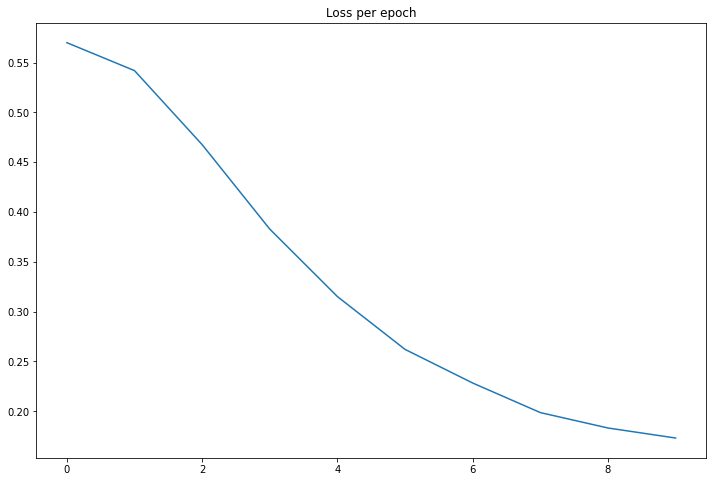

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

epoch_loss = []
window = len(train_loss) // 10
for i in range(10):
  start = i * window
  end = start + window
  epoch_loss.append(np.mean(train_loss[start:end]))

plt.figure(figsize=(12,8))
plt.plot(np.arange((len(epoch_loss))), epoch_loss)
plt.title("Loss per epoch")
plt.show()

In [ ]:
results = """
Label 0: 0.750, 1.000, 0.857
        Label 1: nan, 0.000, nan
        Acc. (Correct/Total): 0.7499 (2606/3475) 

Label 0: 0.759, 0.981, 0.856
        Label 1: 0.533, 0.064, 0.115
        Acc. (Correct/Total): 0.7519 (2613/3475) 

Label 0: 0.778, 0.890, 0.830
        Label 1: 0.421, 0.241, 0.306
        Acc. (Correct/Total): 0.7275 (2528/3475) 

Label 0: 0.778, 0.902, 0.835
        Label 1: 0.435, 0.227, 0.298
        Acc. (Correct/Total): 0.7329 (2547/3475) 

Label 0: 0.776, 0.904, 0.835
        Label 1: 0.428, 0.216, 0.287
        Acc. (Correct/Total): 0.7318 (2543/3475) 
Label 0: 0.777, 0.911, 0.839
        Label 1: 0.446, 0.215, 0.290
        Acc. (Correct/Total): 0.7370 (2561/3475) 
Label 0: 0.777, 0.910, 0.838
        Label 1: 0.447, 0.217, 0.293
        Acc. (Correct/Total): 0.7370 (2561/3475) 
Label 0: 0.781, 0.882, 0.828
        Label 1: 0.421, 0.257, 0.319
        Acc. (Correct/Total): 0.7258 (2522/3475) 
Label 0: 0.778, 0.867, 0.820
        Label 1: 0.392, 0.257, 0.310
        Acc. (Correct/Total): 0.7145 (2483/3475) 
Label 0: 0.777, 0.901, 0.834
        Label 1: 0.430, 0.224, 0.295
        Acc. (Correct/Total): 0.7315 (2542/3475) 

Label 0: 0.775, 0.912, 0.838
        Label 1: 0.437, 0.205, 0.279
        Acc. (Correct/Total): 0.7353 (2555/3475) 

Label 0: 0.777, 0.905, 0.836
        Label 1: 0.436, 0.221, 0.293
        Acc. (Correct/Total): 0.7338 (2550/3475) 

Label 0: 0.781, 0.896, 0.835
        Label 1: 0.442, 0.247, 0.317
        Acc. (Correct/Total): 0.7338 (2550/3475) 

Label 0: 0.788, 0.852, 0.819
        Label 1: 0.412, 0.312, 0.355
        Acc. (Correct/Total): 0.7168 (2491/3475) 


Label 0: 0.778, 0.848, 0.812
Label 1: 0.377, 0.276, 0.319
Acc. (Correct/Total): 0.7050 (2450/3475)

Label 0: 0.778, 0.848, 0.812
Label 1: 0.377, 0.276, 0.319
Acc. (Correct/Total): 0.7050 (2450/3475)


Label 0: 0.777, 0.883, 0.827
Label 1: 0.408, 0.242, 0.303
Acc. (Correct/Total): 0.7226 (2511/3475)

Label 0: 0.778, 0.895, 0.832
Label 1: 0.427, 0.235, 0.303
Acc. (Correct/Total): 0.7298 (2536/3475)

Label 0: 0.782, 0.852, 0.816
Label 1: 0.394, 0.288, 0.332
Acc. (Correct/Total): 0.7111 (2471/3475)

Label 0: 0.780, 0.862, 0.819
Label 1: 0.397, 0.273, 0.323
Acc. (Correct/Total): 0.7145 (2483/3475)
"""

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import re

acc_indices = [m.start() for m in re.finditer("Total", results)]

In [ ]:
accs = []
for i in acc_indices:
  accs.append(float(results[i+8:i+13]))

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(range(1, len(accs) + 1), accs)
plt.title("Dev Accuracy per epoch", fontsize=20)
plt.xticks(range(1, len(accs) + 1))
plt.show()